In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.transforms as mplTransforms
from matplotlib.path import Path
from JSAnimation import IPython_display




In [8]:
"""
Useful functions for reflection

"""
def find_nearest_normal(point,path):
    ## Find the normal vector to a path that is closest to a point
    num_vertices = np.size(path.vertices[0:-1,0])
    distances = np.zeros((num_vertices))
    for i in range(num_vertices):
        ## For every line segment, find the distance
        line_segment = path.vertices[i+1]-path.vertices[i]
        line_to_point = path.vertices[i+1]-point
        distances[i] = np.linalg.norm(np.cross(line_to_point,line_segment))/np.linalg.norm(line_segment)
    ## The closest line has the least distance. Find the starting vertex and the line segment
    nearest_line_start_vertex = path.vertices[np.argmin(distances)]
    line_vector = path.vertices[np.argmin(distances)+1] - path.vertices[np.argmin(distances)] 
    nearest_normal = np.array([[0,-1],[1,0]]).dot(line_vector) ## The normal vector is [-b,a]
    return nearest_normal/np.linalg.norm(nearest_normal)  ## Make it a unit vector

def rotation_2D(theta):
    ## 2D Rotation matrix
    theta = theta * math.pi/180
    c, s = np.cos(theta), np.sin(theta)
    return np.matrix([[c, -s], [s, c]])

def rotate_path(path,theta):
    ## Rotate a path
    R = rotation_2D(theta)
    verts = path.vertices
    num_verts = np.size(verts[:,1])
    verts_new = np.zeros((num_verts,2))
    for i in range(num_verts):
        verts_new[i,:] = R.dot(verts[i])

    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]

    return Path(verts_new, codes)

"""

Class definition for the box.

    Methods:
        - box = Box(500): Initialize a 500 particle box
        - box.animate(): video of the atoms flying in the box
        - box.momentum_focus(): simulate the momentum focusing observation
        
"""


class Box():
    
    def __init__(self, NumParticles=500,theta=0):
        ## Initial properties
        self.omega = 1.25
        self.dt = 0.005
        self.k_F = 2
        self.NumParticles = NumParticles
        
        ## Box shape - shear tilted
        verts = [
            (-0.5, -2), # left, bottom
            (-0.4, 2), # left, top
            (0.4, 2), # right, top
            (0.5, -2), # right, bottom
            (-0.5, -2), # ignored
                ]

        codes = [Path.MOVETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.CLOSEPOLY,
                 ]

        self.box_path = Path(verts, codes)
        self.box_path = rotate_path(self.box_path,theta)
        
        
        ## Initial positions - make sure they're inside the box to begin with
        self.positions = np.zeros((1,2))
        
        while np.size(self.positions[:,0])<(NumParticles):
            point_try = [1,0.5]*(np.random.rand(2)-0.5)
            if self.box_path.contains_point(point_try):
                self.positions = np.vstack((self.positions,[point_try]))
        
        ## Momentum distribution (Assuming T=0)
        r_points = self.k_F*np.random.rand(NumParticles,1) 
        theta_points = 2*math.pi*np.random.rand(NumParticles,1)
        
        self.velocities = np.zeros((NumParticles,2))
        self.velocities = np.hstack((np.sqrt(r_points)*np.cos(theta_points),
                               np.sqrt(r_points)*np.sin(theta_points)))
        
        
    def update_positions(self):
        
        ## Update the box forward in time to t+dt
        step = self.velocities*self.dt

        positions_test = self.positions + step
          
        ## If a particle hits a wall, reflect it
        for j in range(np.size(self.positions[:,1])):
            ## Take every particle, and check if it's in the box_path
            if not(self.box_path.contains_point(positions_test[j,:])):
                ## Find the  outward-pointing normal vector
                normal = find_nearest_normal(positions_test[j,:],self.box_path)
                ## Reflect about normal vector
                self.velocities[j,:] = self.velocities[j,:] - 2*(normal.dot(self.velocities[j,:]))*normal

        ## Advance
        step = self.velocities*self.dt
        self.positions = self.positions + step
        self.velocities[:,1] = self.velocities[:,1] - self.omega**2 * self.positions[:,1] * self.dt

    def update_plot(self,t,box,scat):
        ## Update the plot for the animation method below
        self.update_positions()
        scat.set_offsets(self.positions)
        return scat

    def animate(self,saveQ=False):
        ## Animate the box 
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(-1, 1), ax.set_xticks([])
        ax.set_ylim(-2.5, 2.5), ax.set_yticks([])
        ax.set_aspect('equal')
        ax.axis('off')
        NumFrames = math.floor(math.pi/(self.dt*2*self.omega))
        ## Draw the box
        patch = patches.PathPatch(self.box_path, fill=False, lw=2)
        ax.add_patch(patch)
        ## Draw everything else
        scat = ax.scatter(self.positions[:,0],self.positions[:,1],
                          s=30, alpha=0.5, color ='r')
        ani = animation.FuncAnimation(fig, box.update_plot, fargs=(self,scat), 
                                      interval=5, frames=2*NumFrames)
        if saveQ:
#             ani.save('../animations/BoxAnim.mp4', writer='ffmpeg',fps=60,bitrate=3000)
            ani.save('../animations/BoxAnim.gif', writer='imagemagick',fps=60)
        else:
            return ani
#             plt.show()

        


    def display(self):
        ## Display the current state of the box
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(-2, 2), ax.set_xticks([])
        ax.set_ylim(-3, 3), ax.set_yticks([])
        ax.set_aspect('equal')
        ## Draw the box
        patch = patches.PathPatch(self.box_path, fill=False, lw=2)
        ax.add_patch(patch)
        ## Draw everything else
        scat = ax.scatter(self.positions[:,0],self.positions[:,1],
                          s=30, alpha=0.5, color ='r')
        plt.show()
        
    def momentum_focus(self):
        ## Momentum focus the box
        NumFrames = math.floor(math.pi/(self.dt*2*self.omega))
        for i in range(NumFrames):
            self.update_positions()
            
        ## Process Data
#         hist, bin_edges = np.histogram(snelf.positions[:,1])
#         plt.plot(bin_edges[0:-1],hist)
        plt.hist(self.positions[:,1],50)
        plt.show()


    


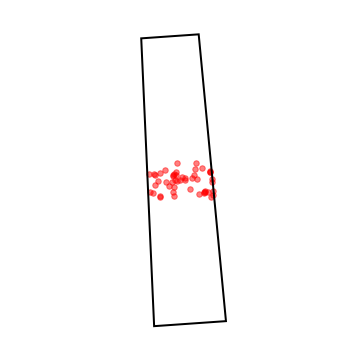
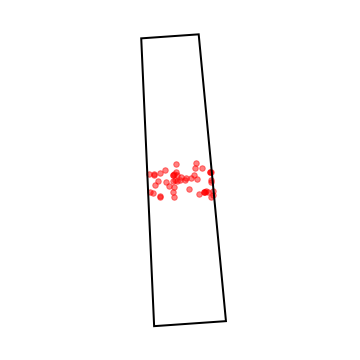
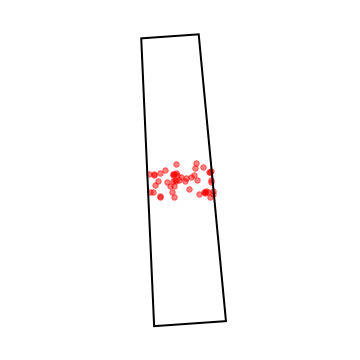
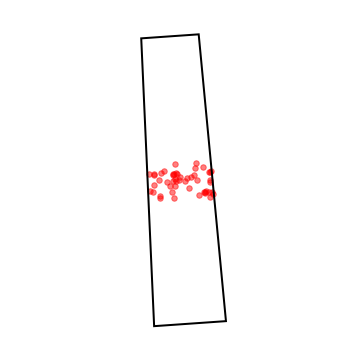
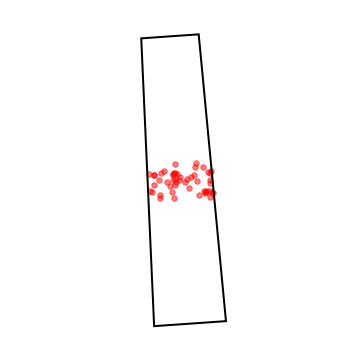
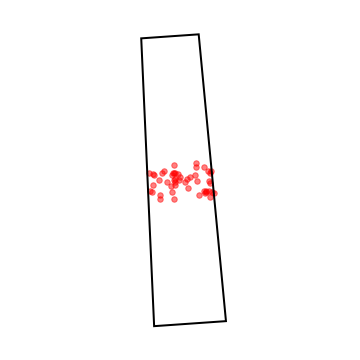
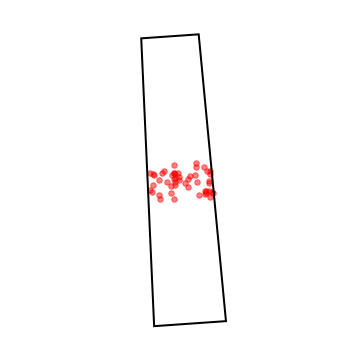
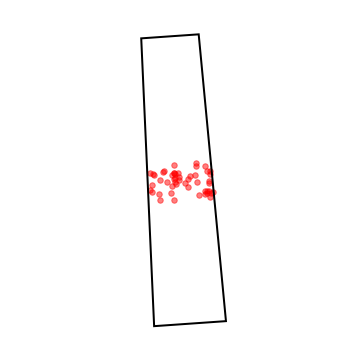
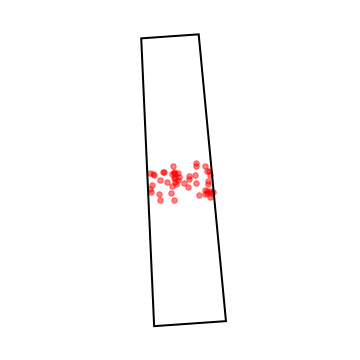
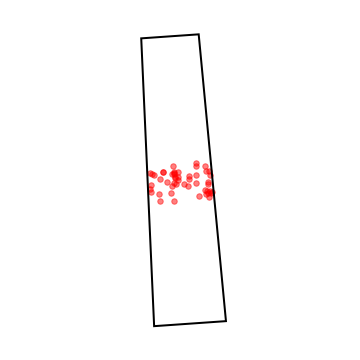
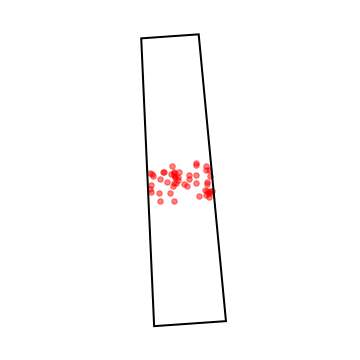
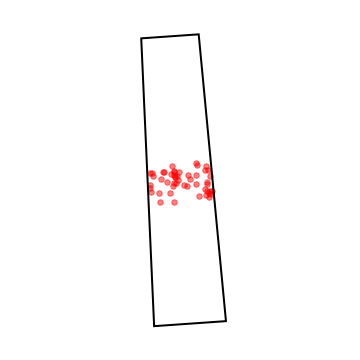
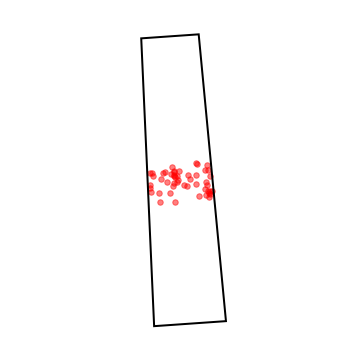
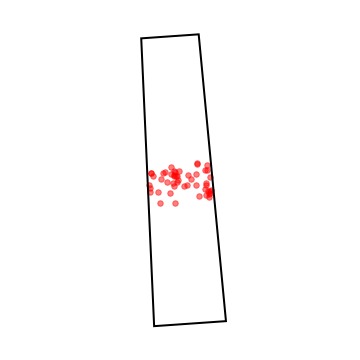
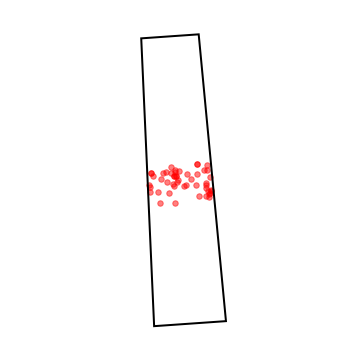
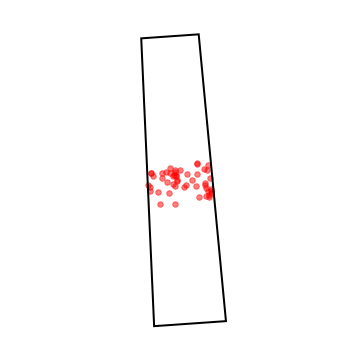
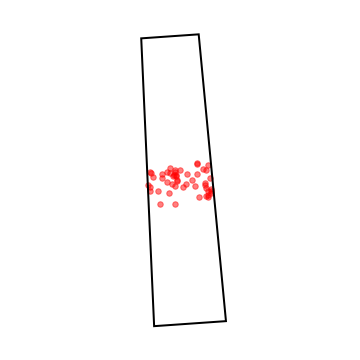
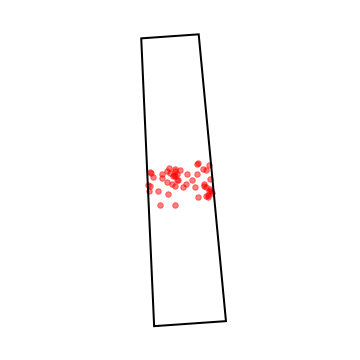
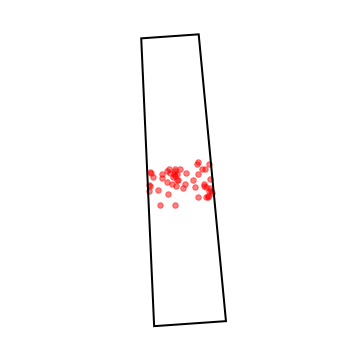
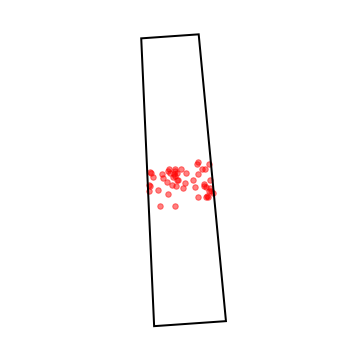
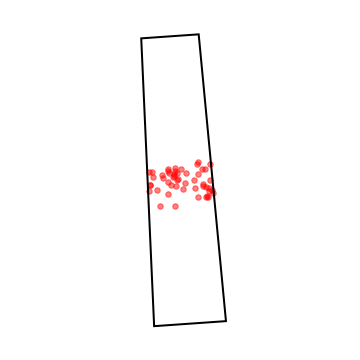
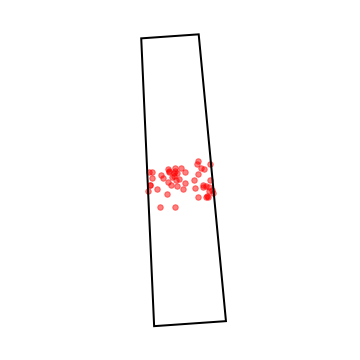
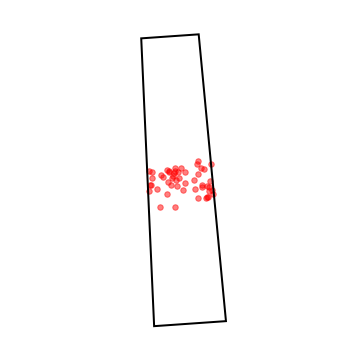
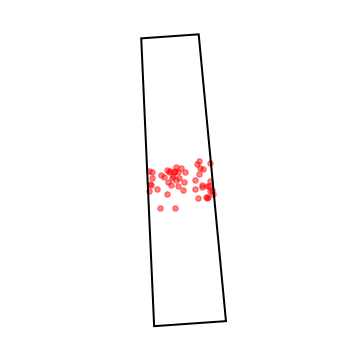
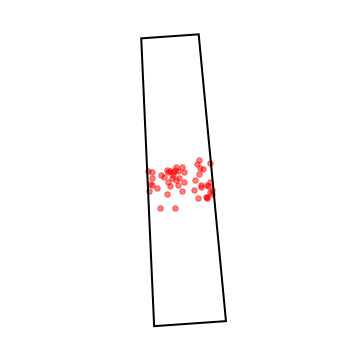
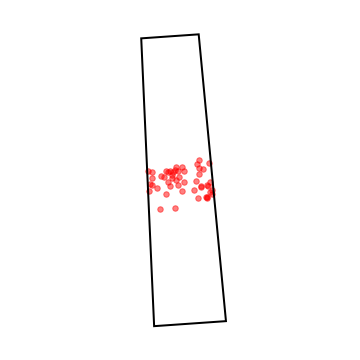
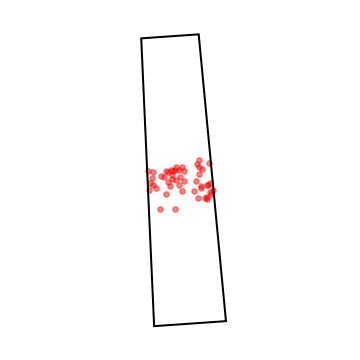
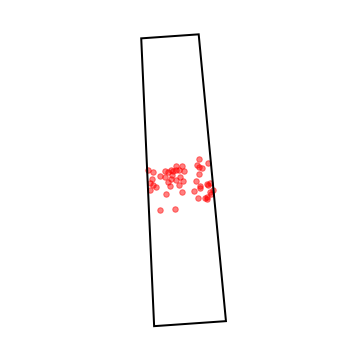
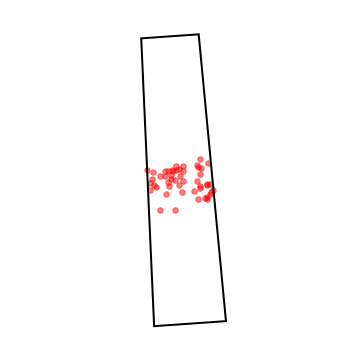
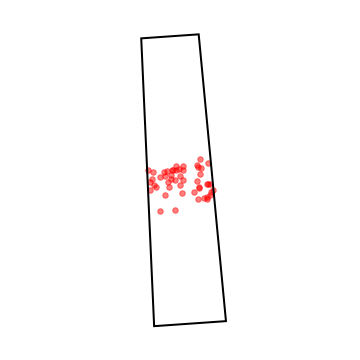
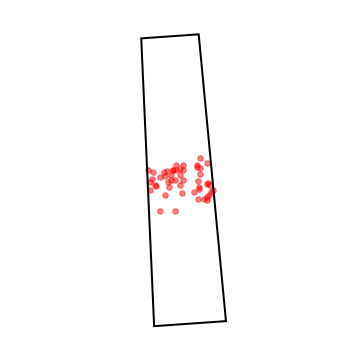
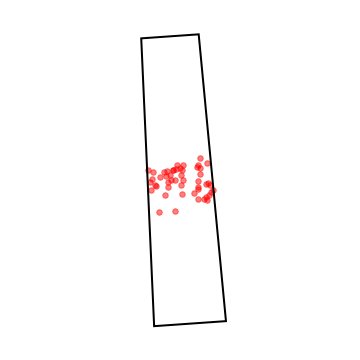
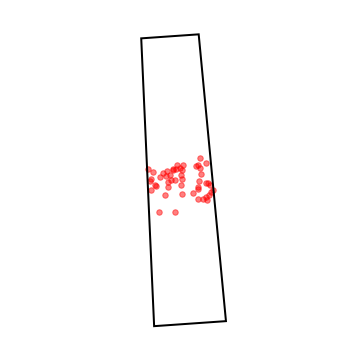
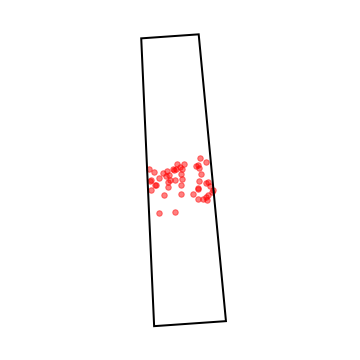
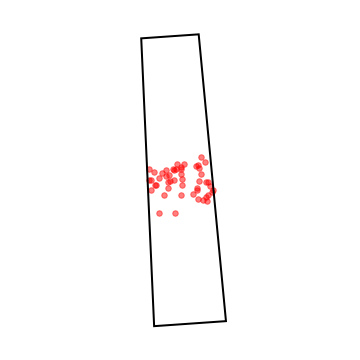
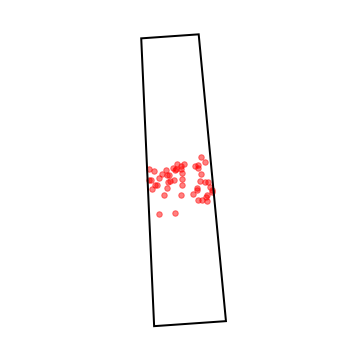
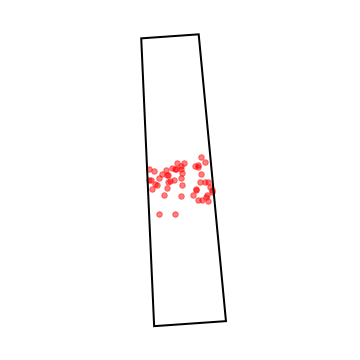
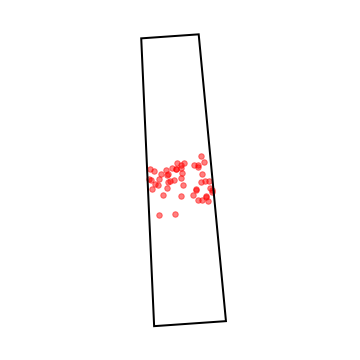
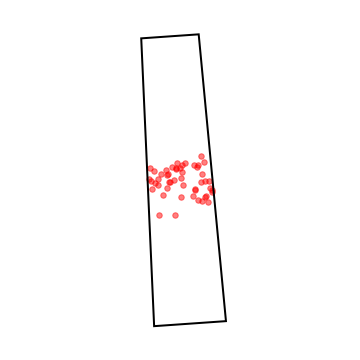
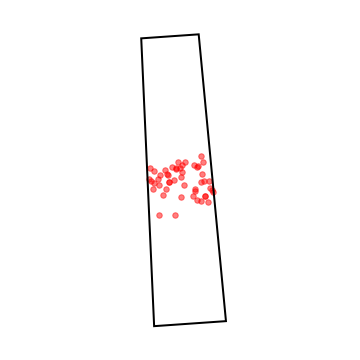
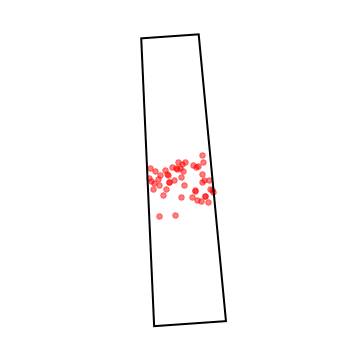
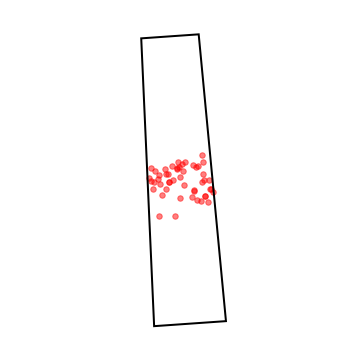
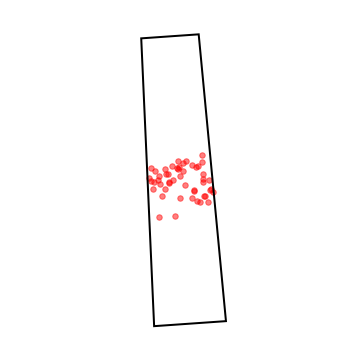
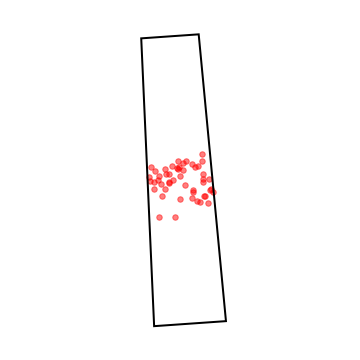
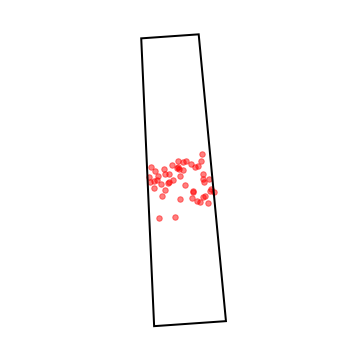
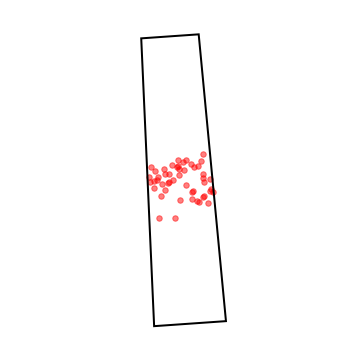
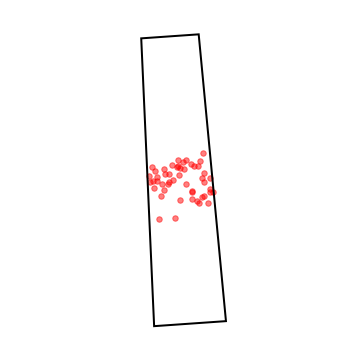
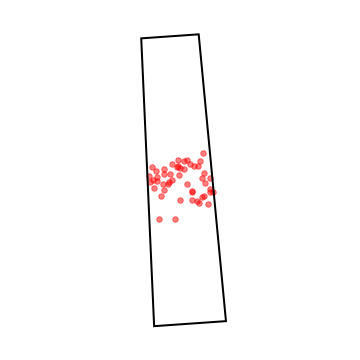
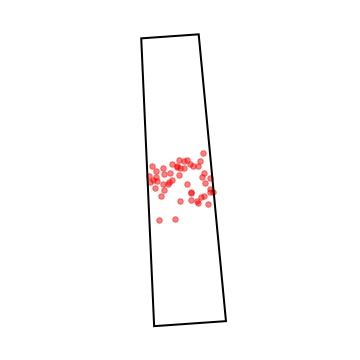
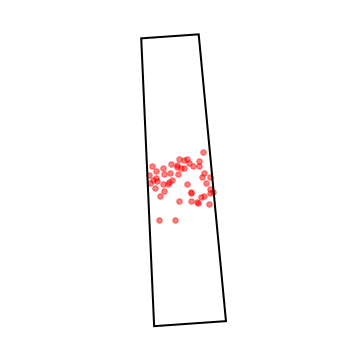
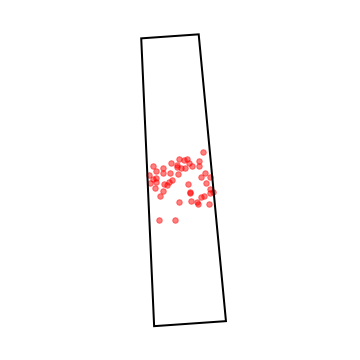
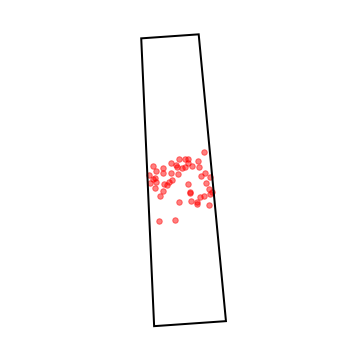
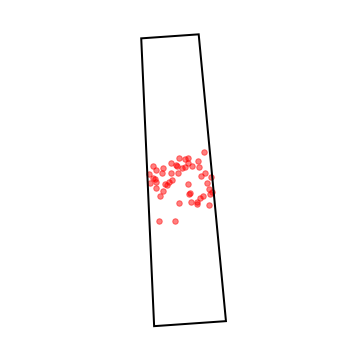
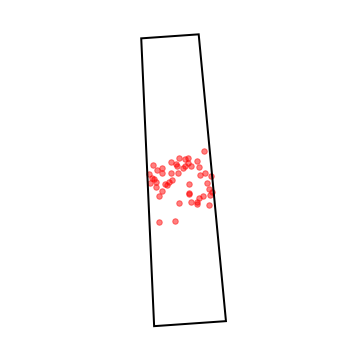
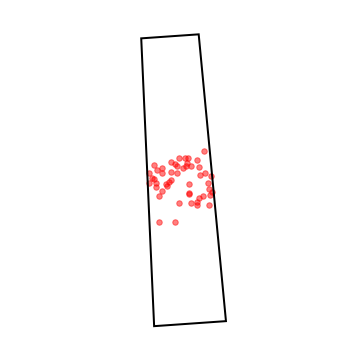
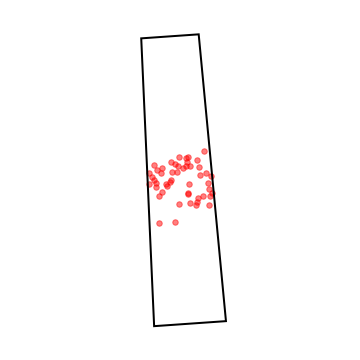
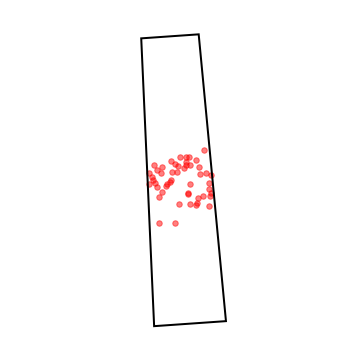
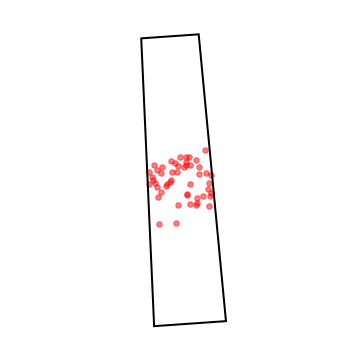
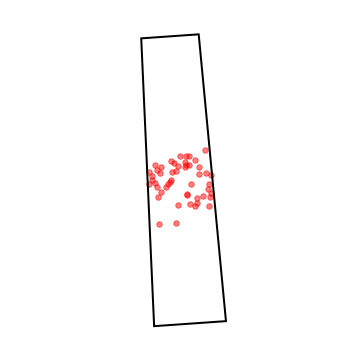
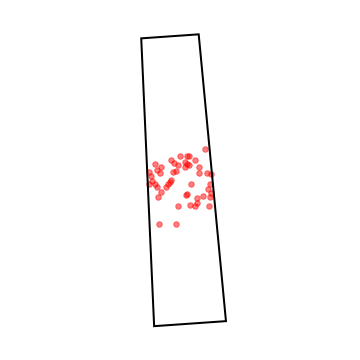
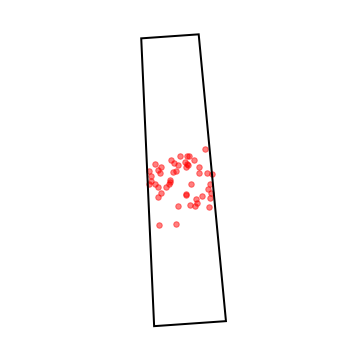
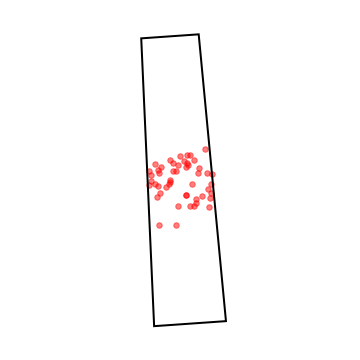
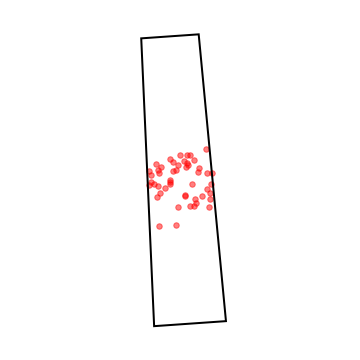
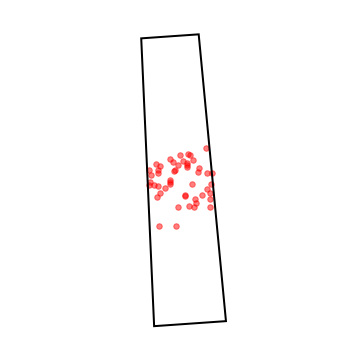
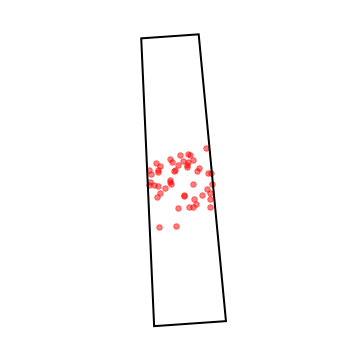
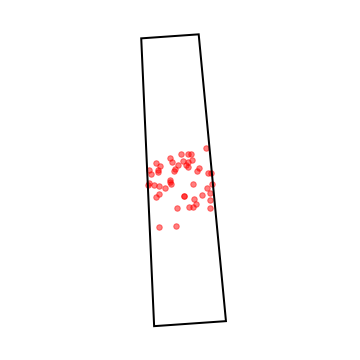
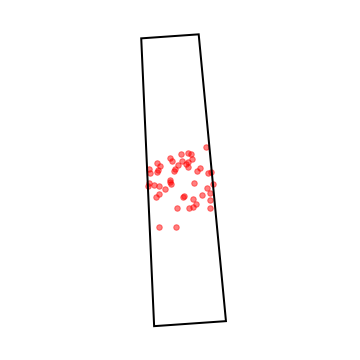
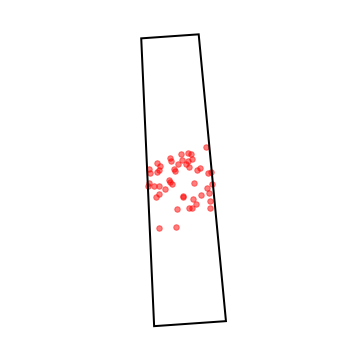
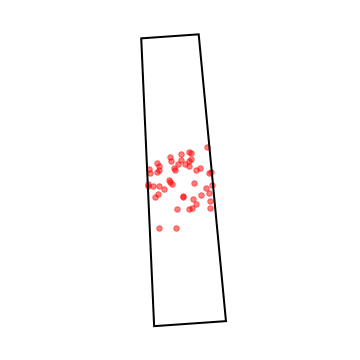
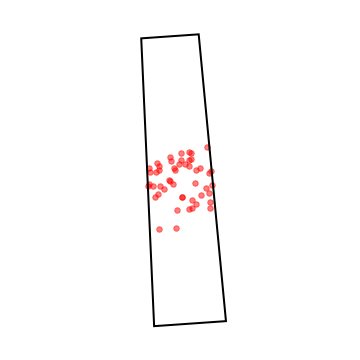
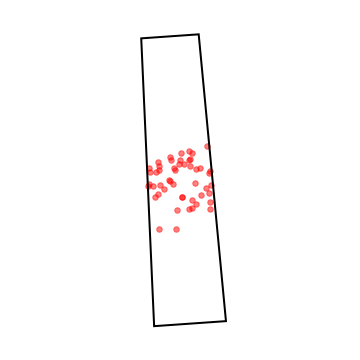
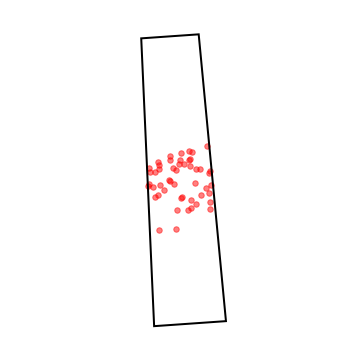
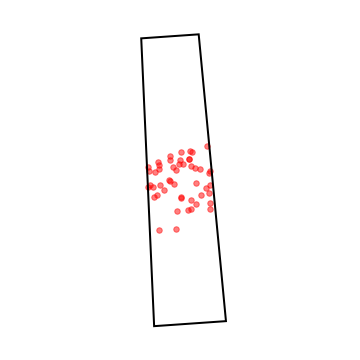
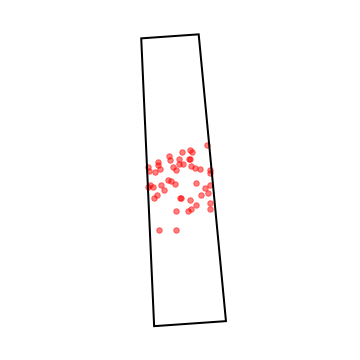
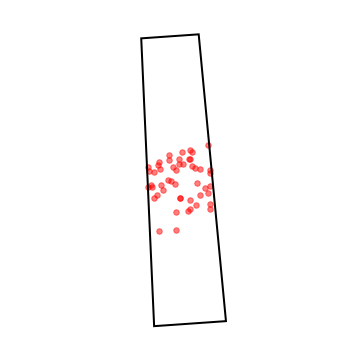
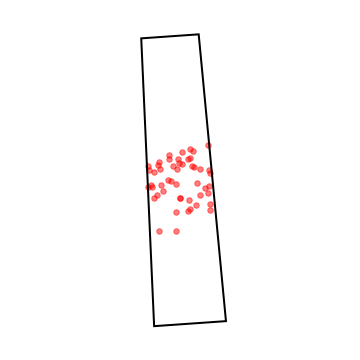
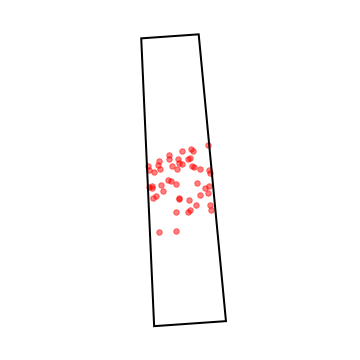
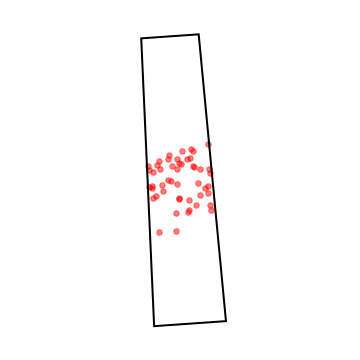
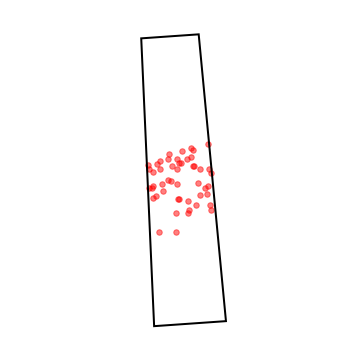
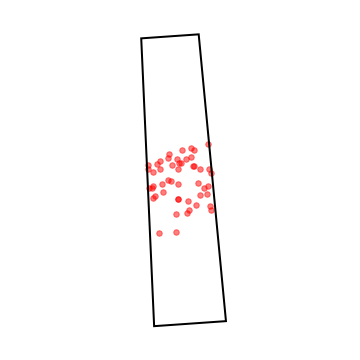
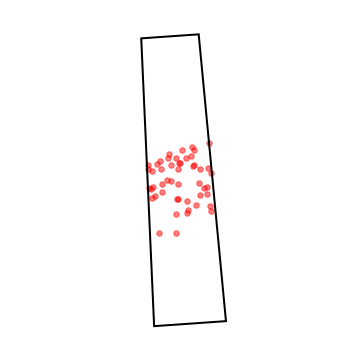
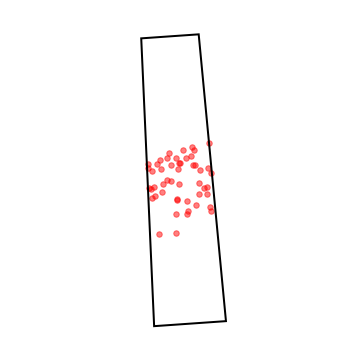
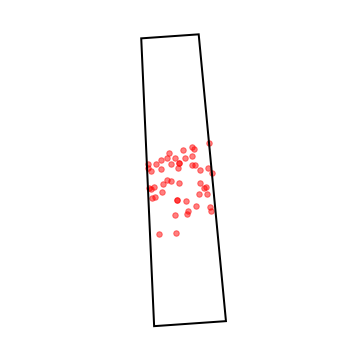
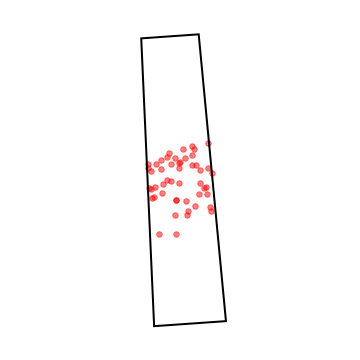
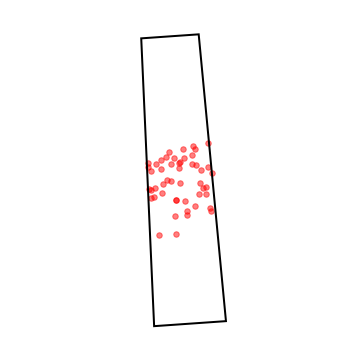
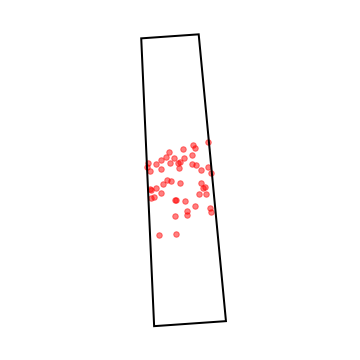
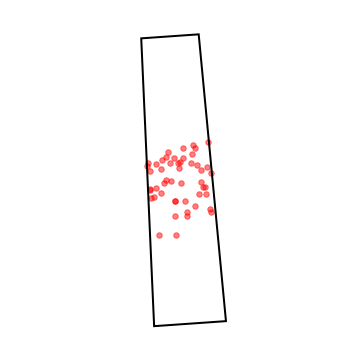
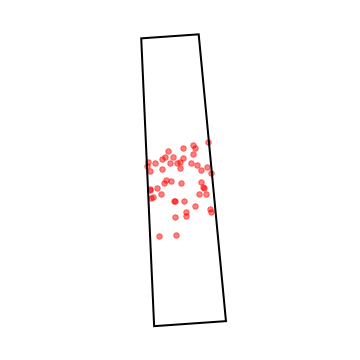
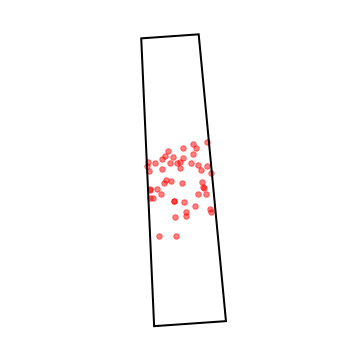
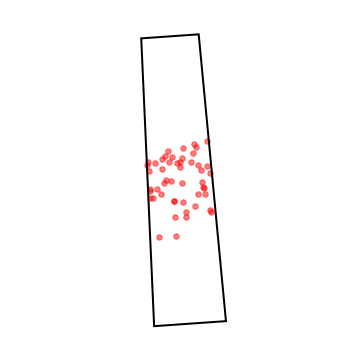
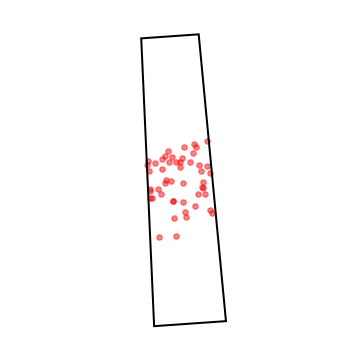
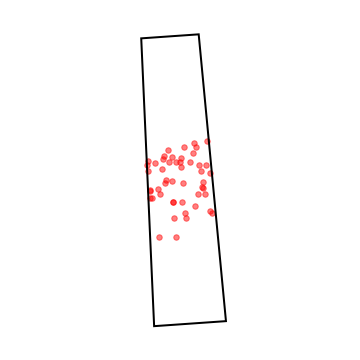
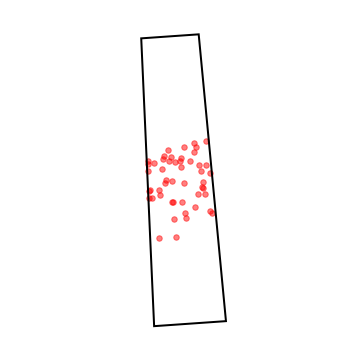
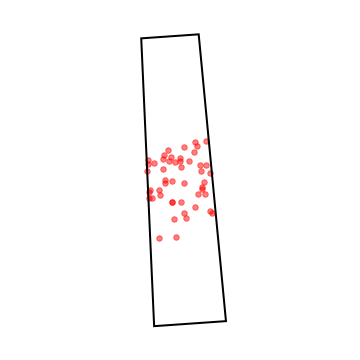
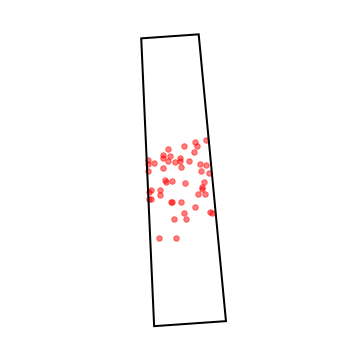
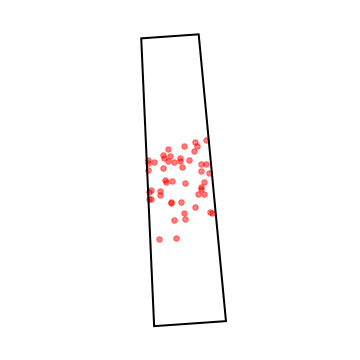
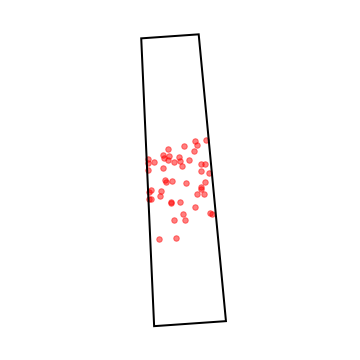
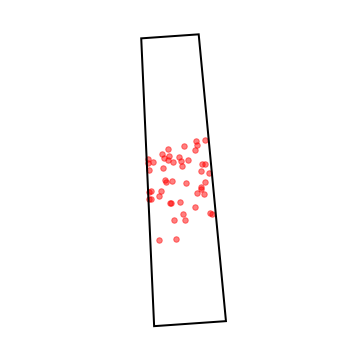
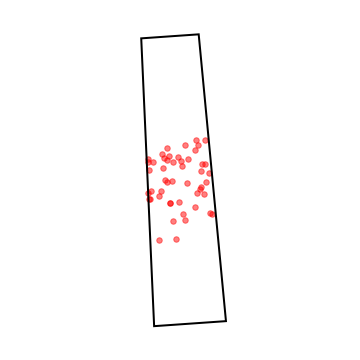
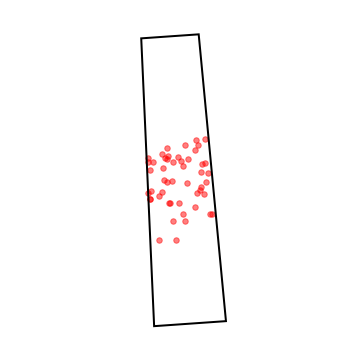
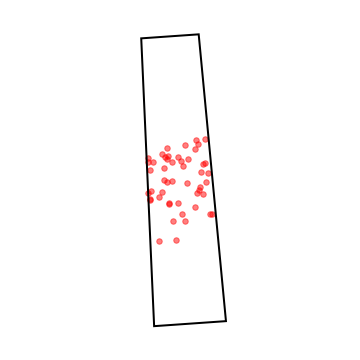
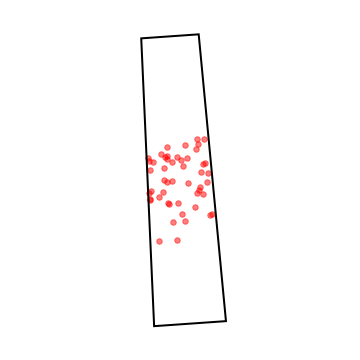
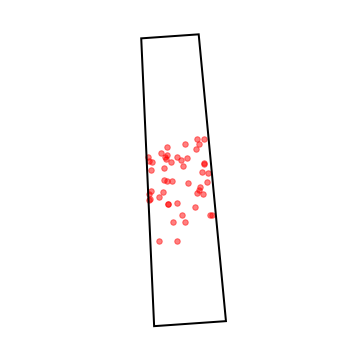
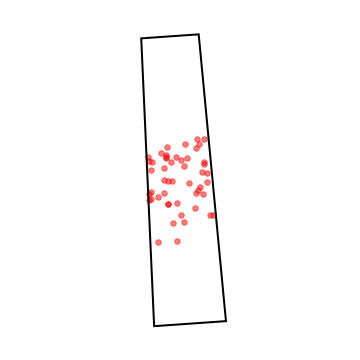
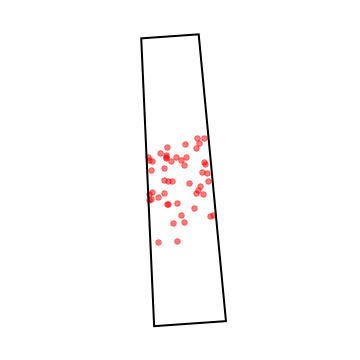
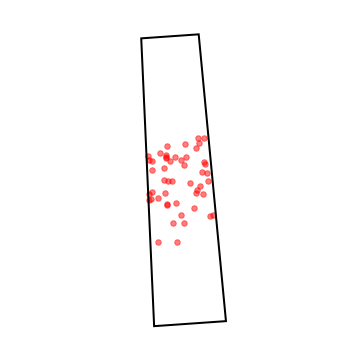
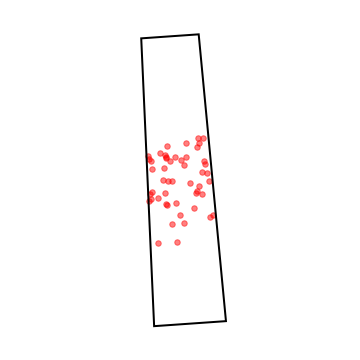
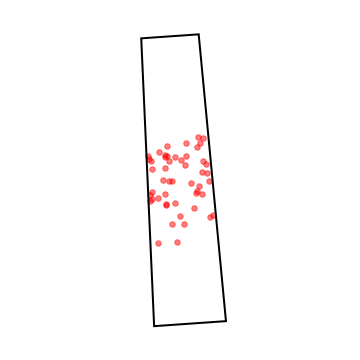
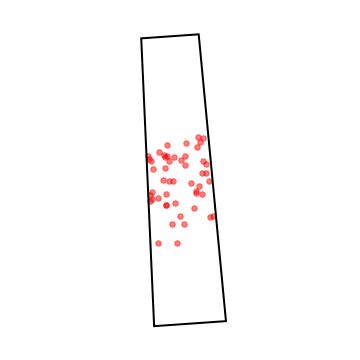
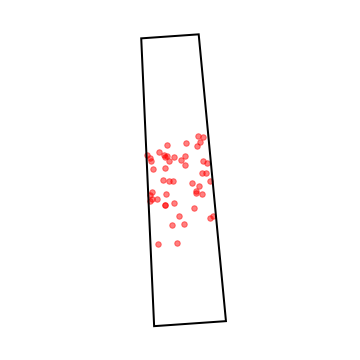
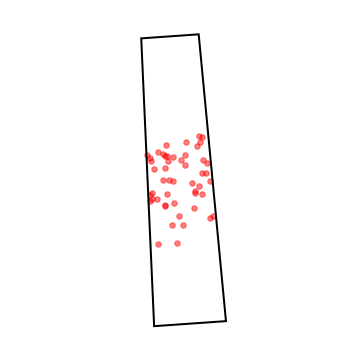
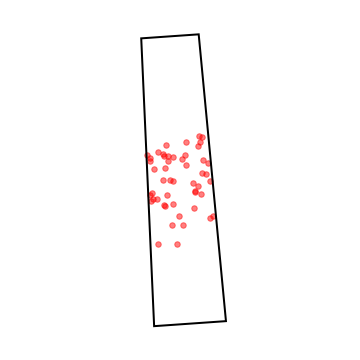
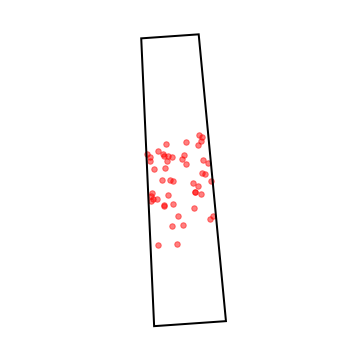
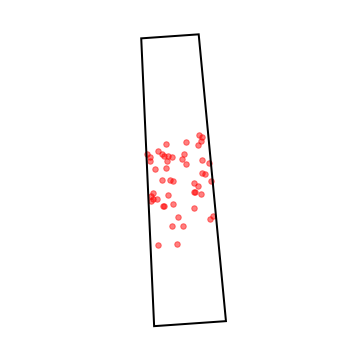
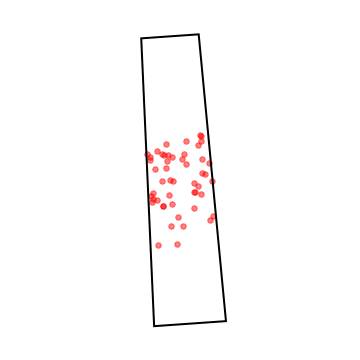
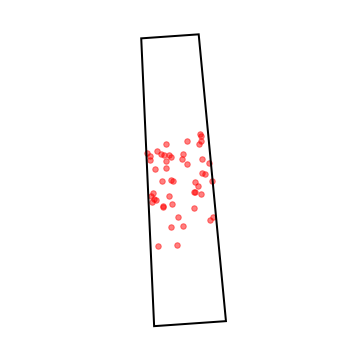
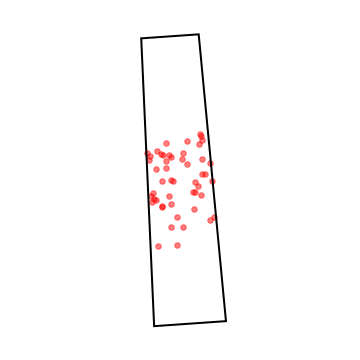
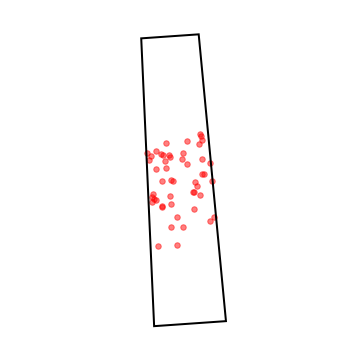
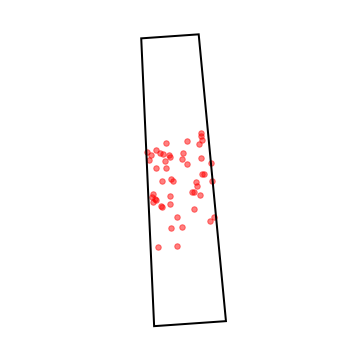
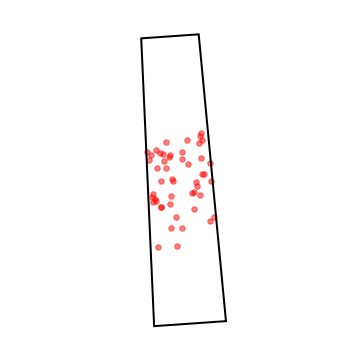
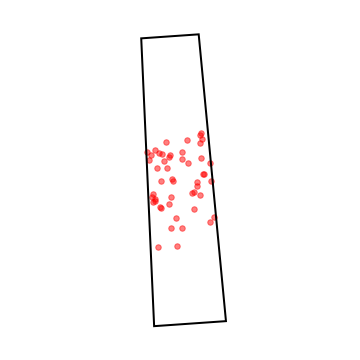
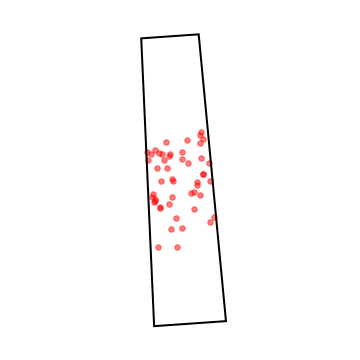
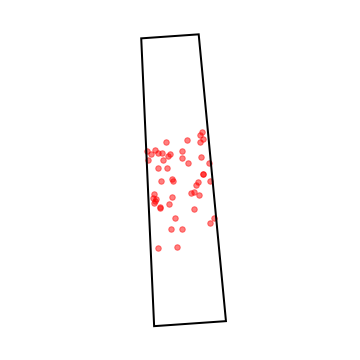
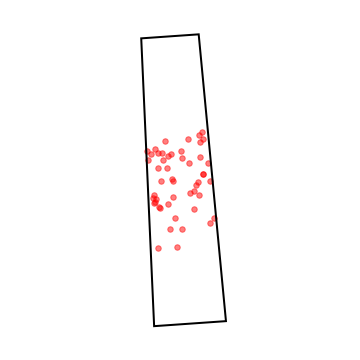
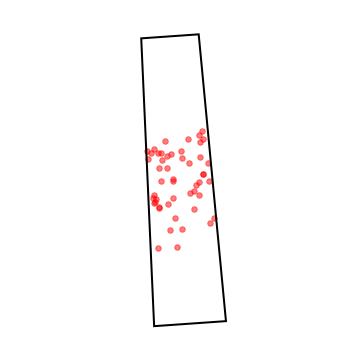
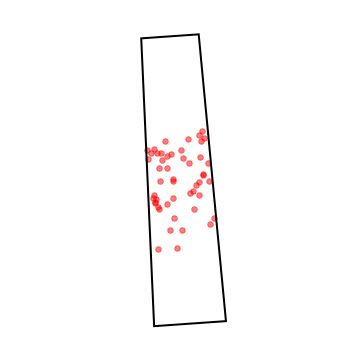
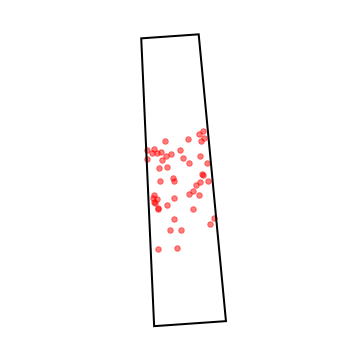
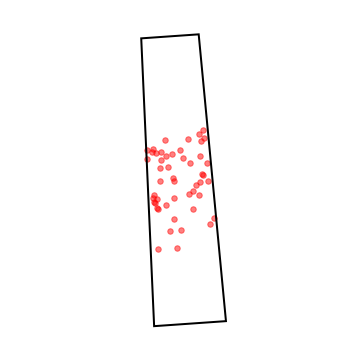
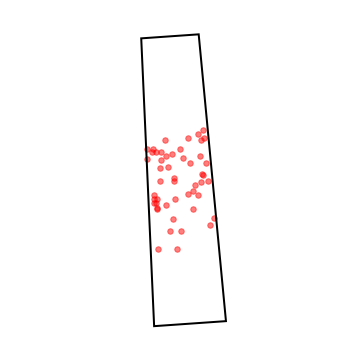
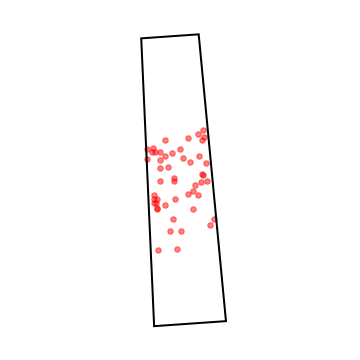
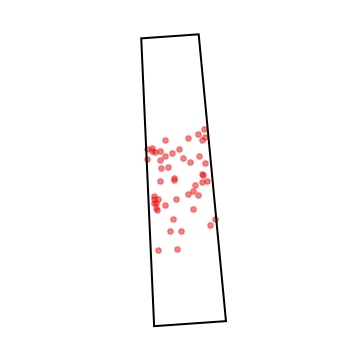
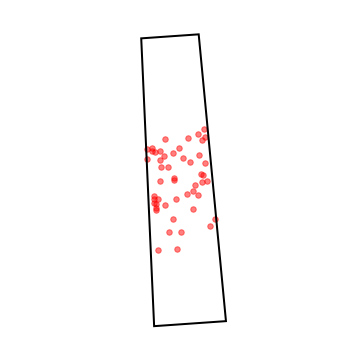
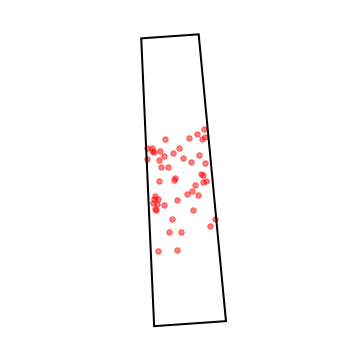
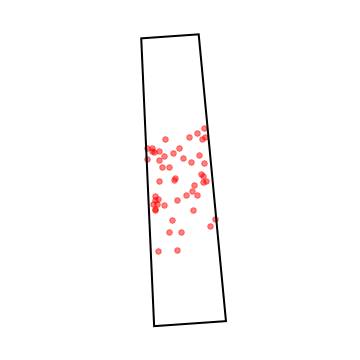
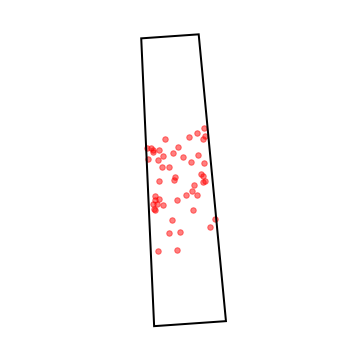
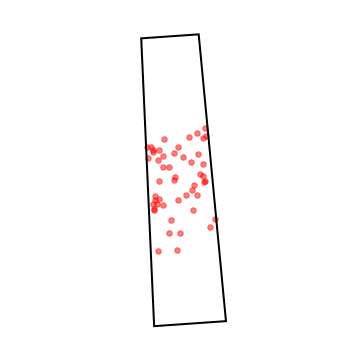
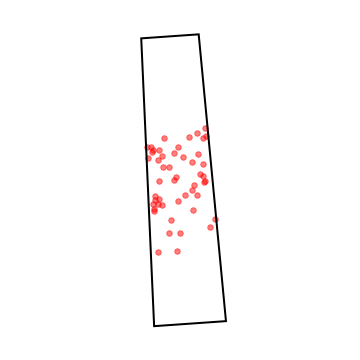
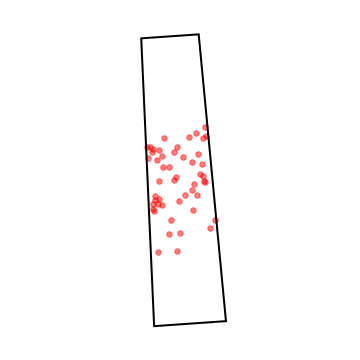
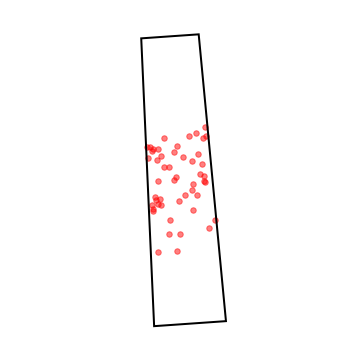
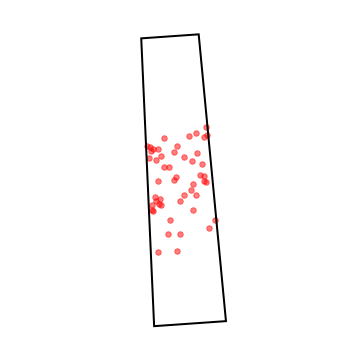
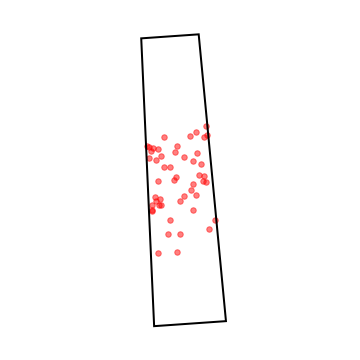
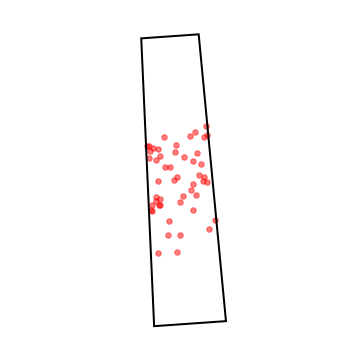
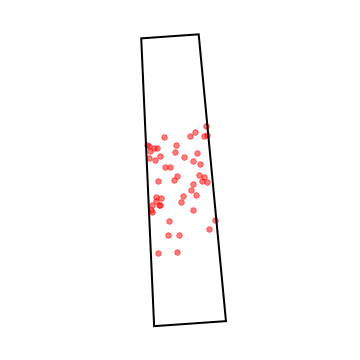
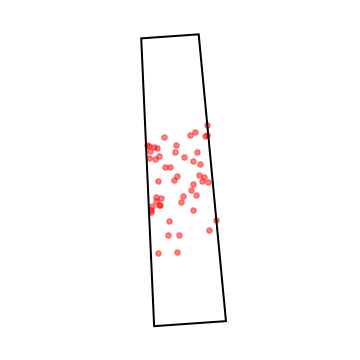
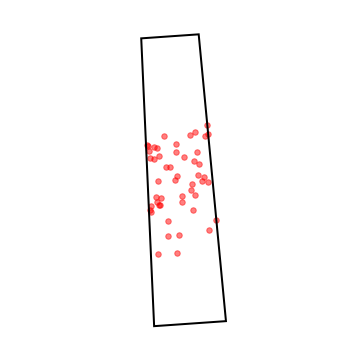
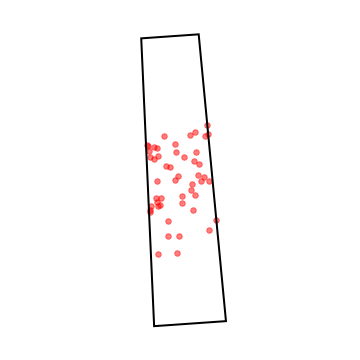
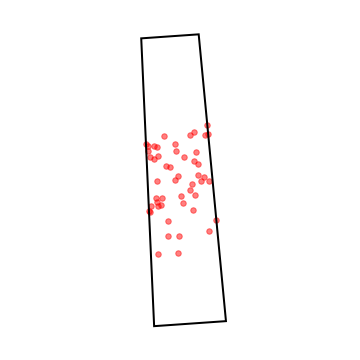
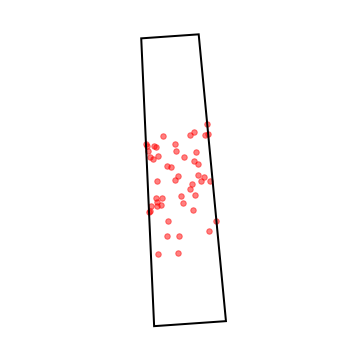
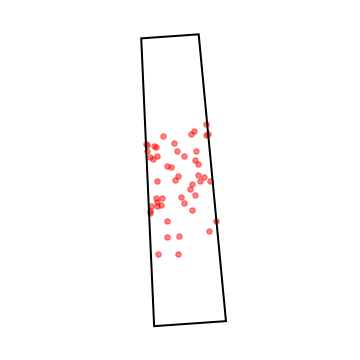
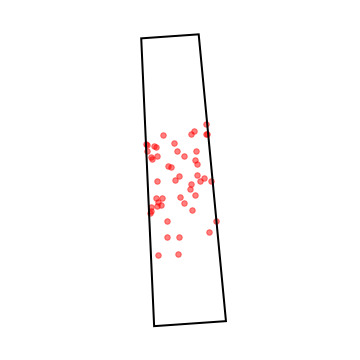
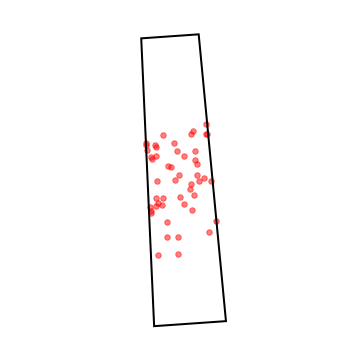
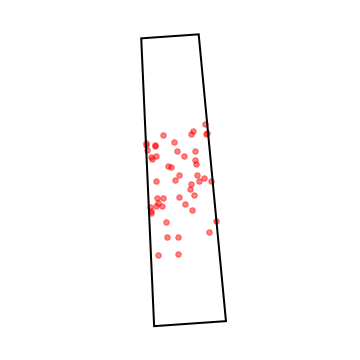
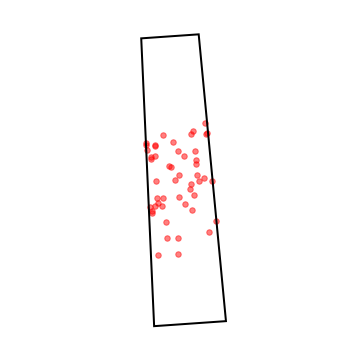
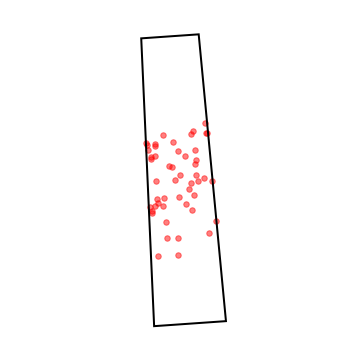
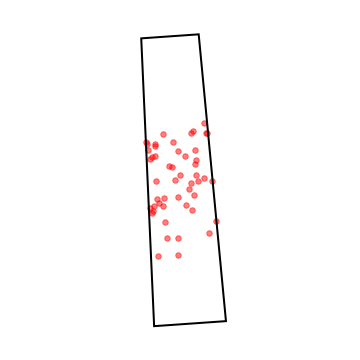
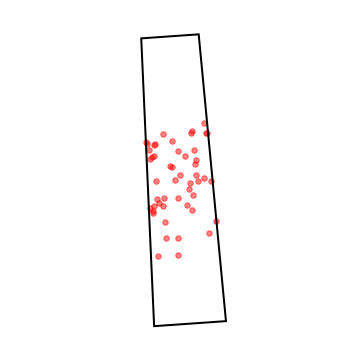
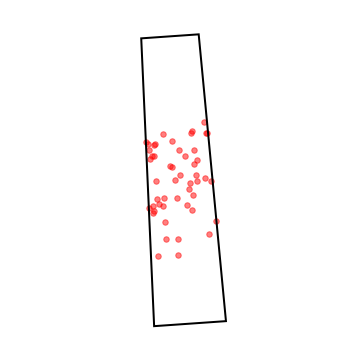
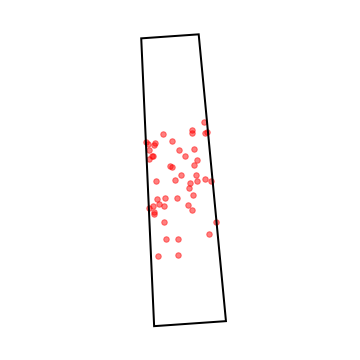
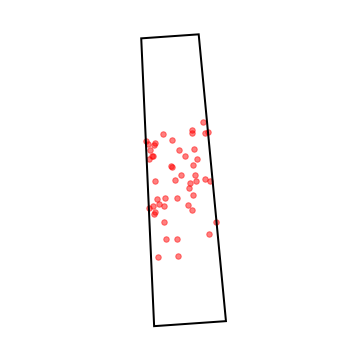
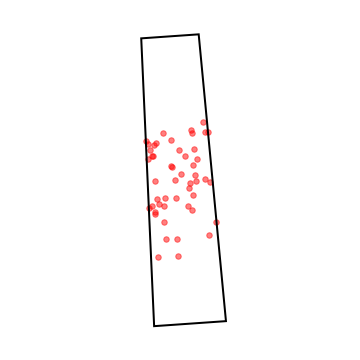
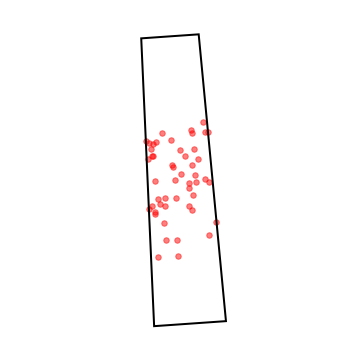
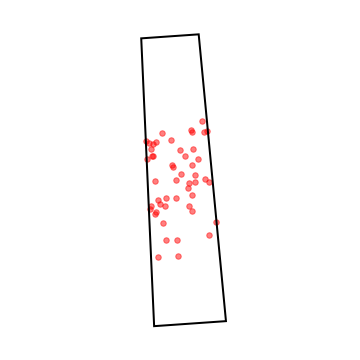
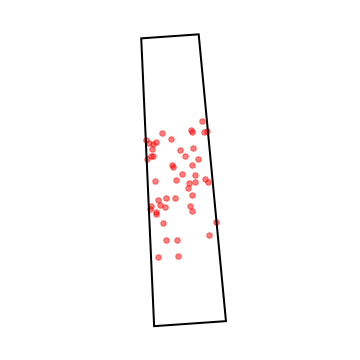
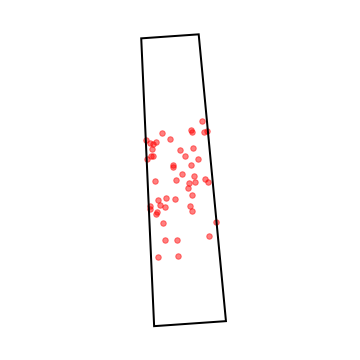
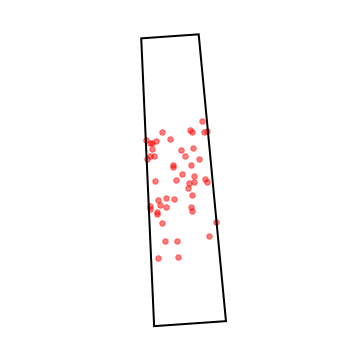
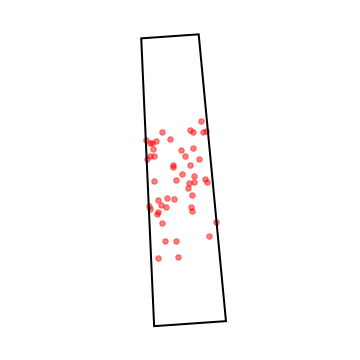
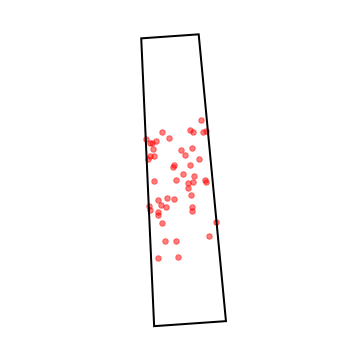
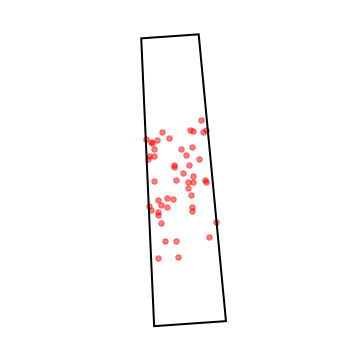
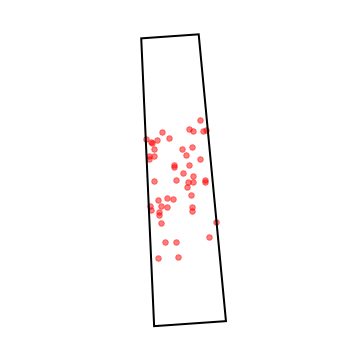
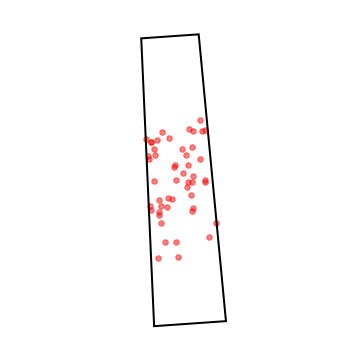
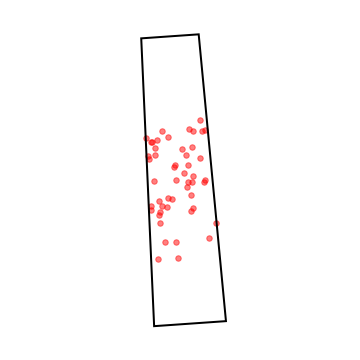
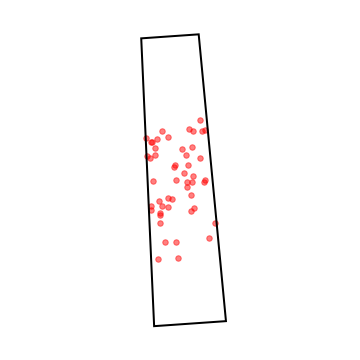
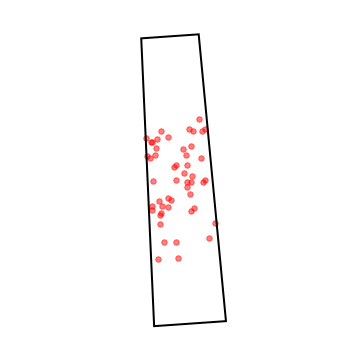
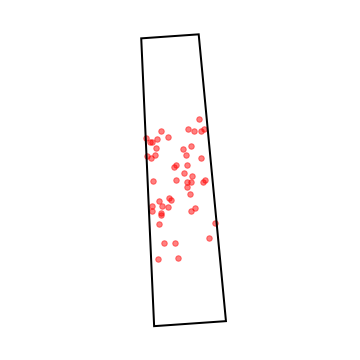
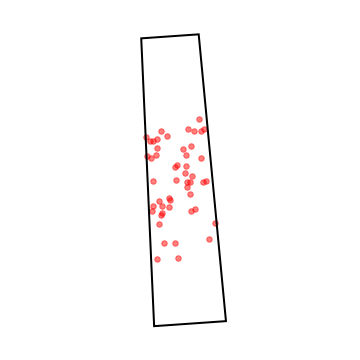
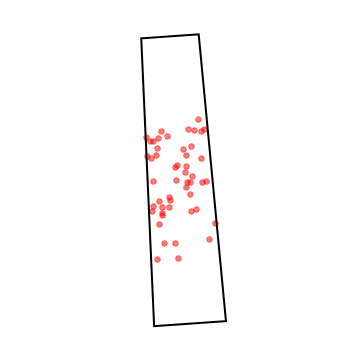
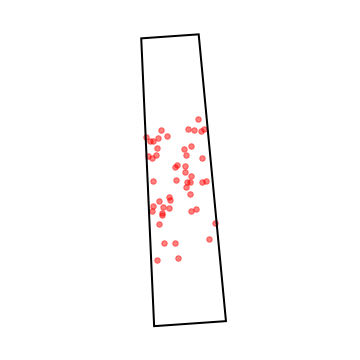
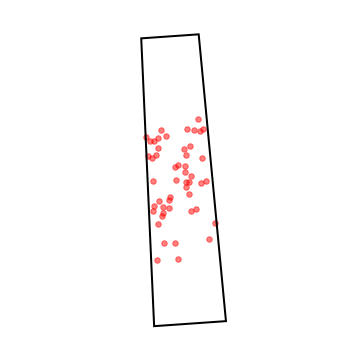
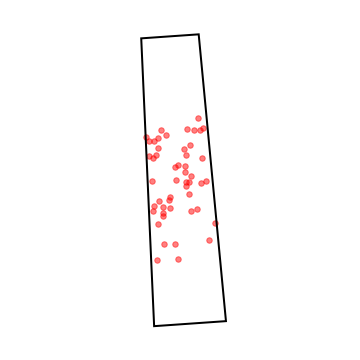
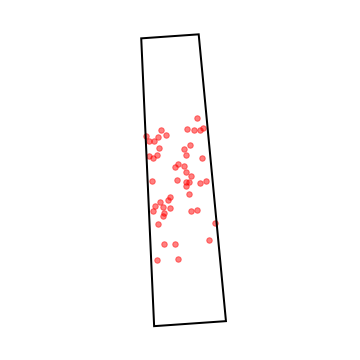
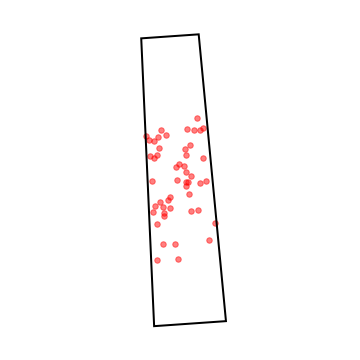
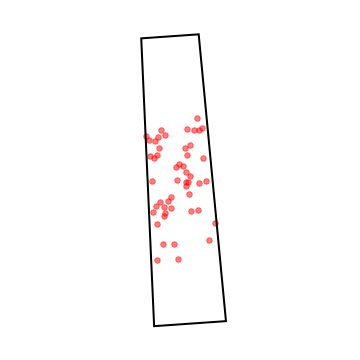
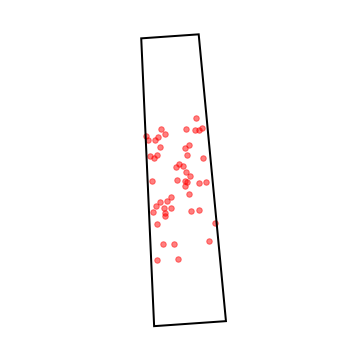
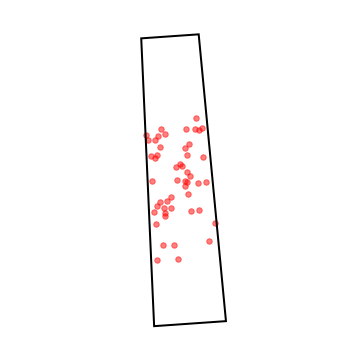
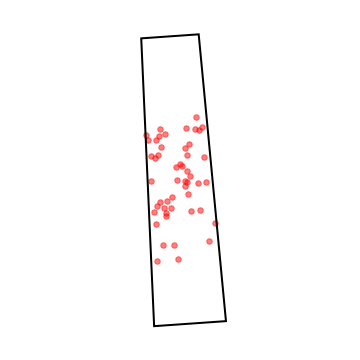
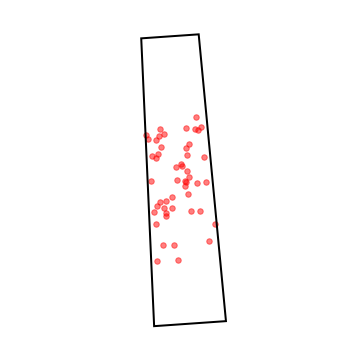
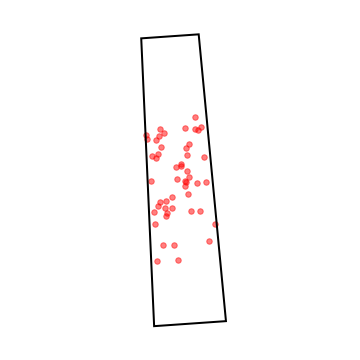
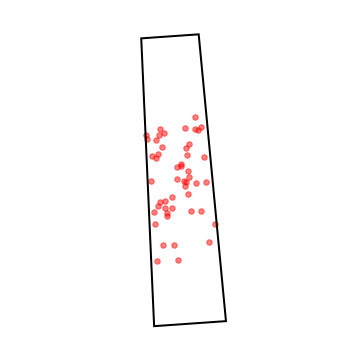
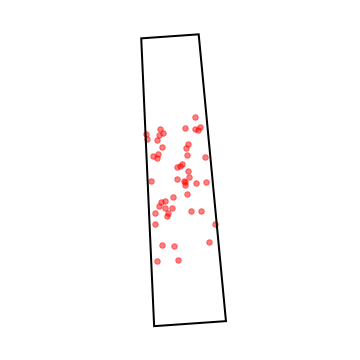
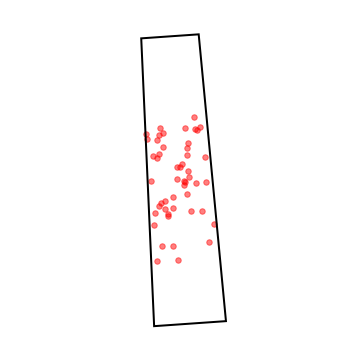
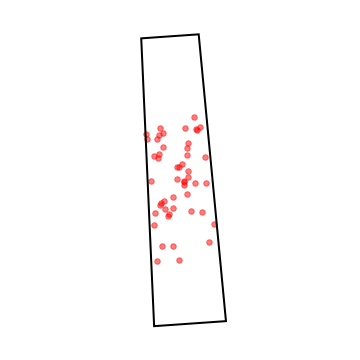
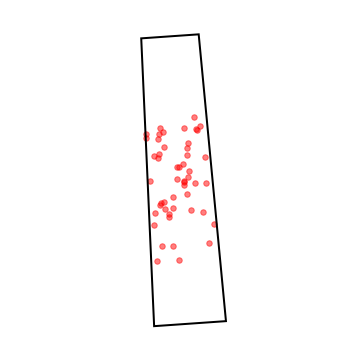
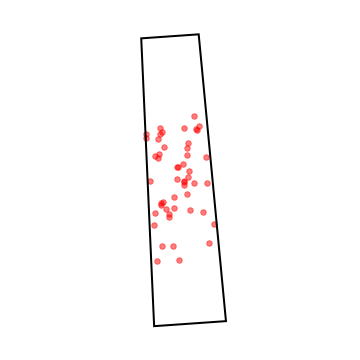
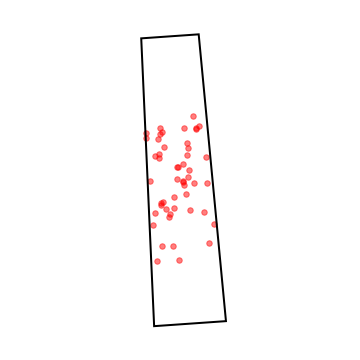
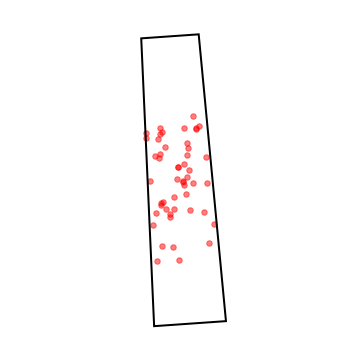
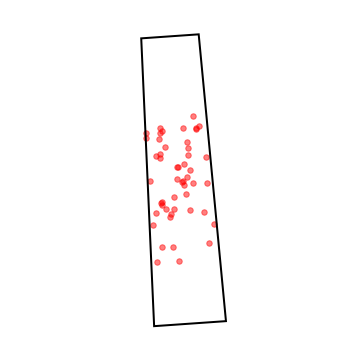
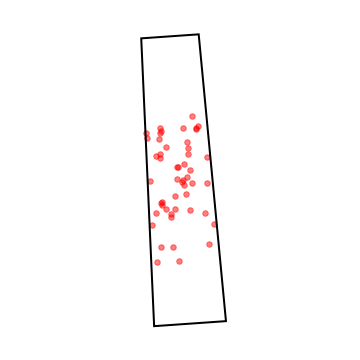
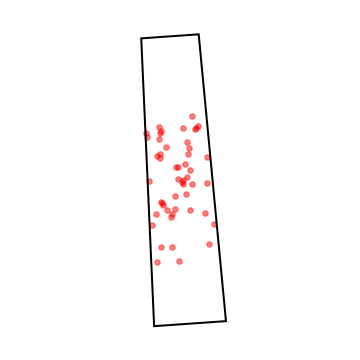
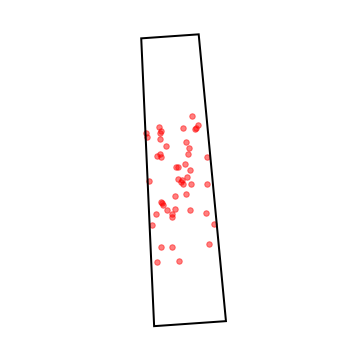
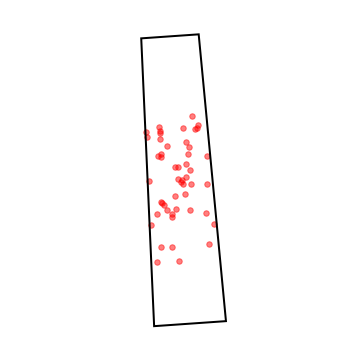
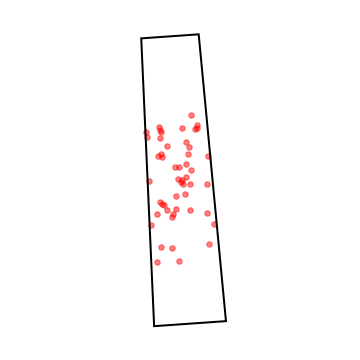
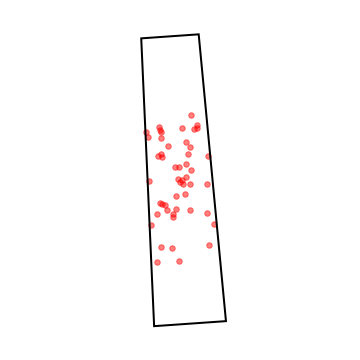
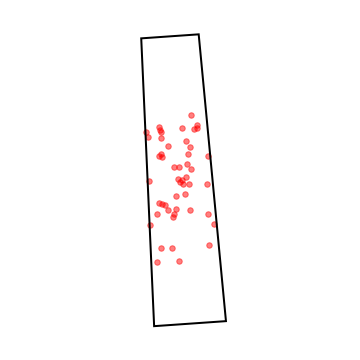
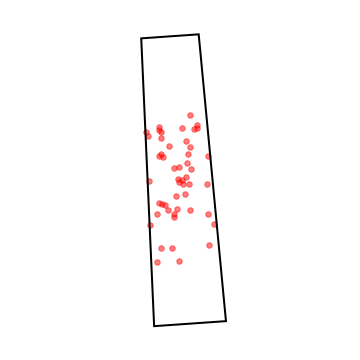
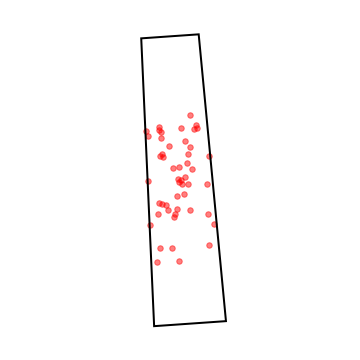
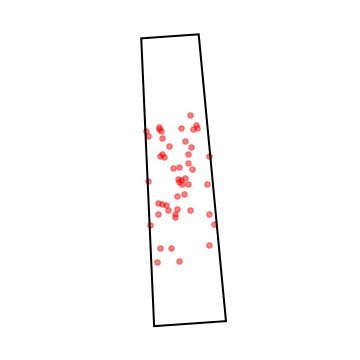
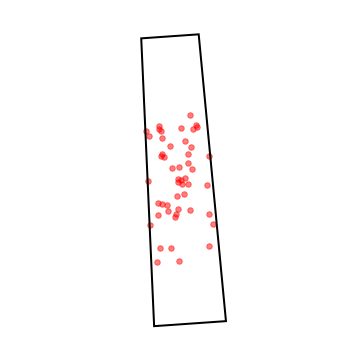
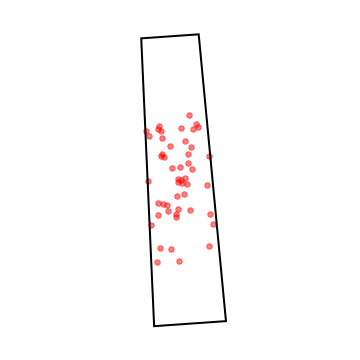
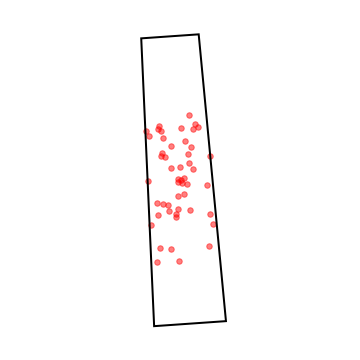
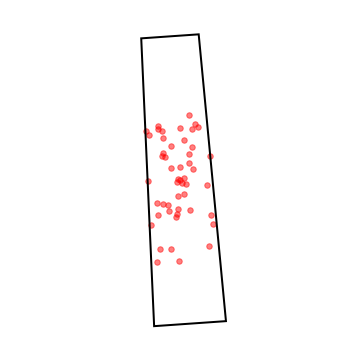
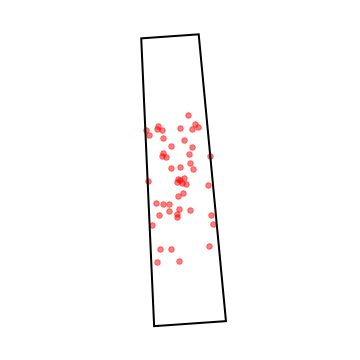
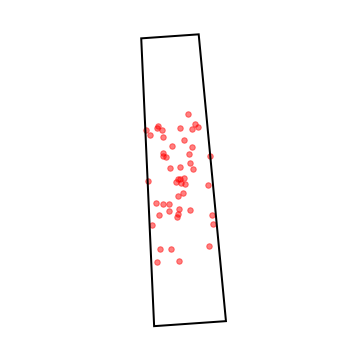
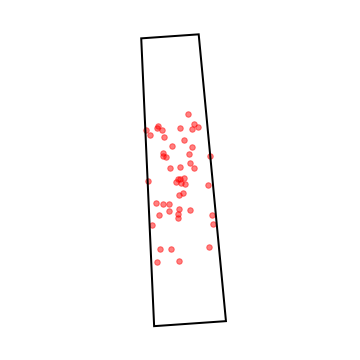
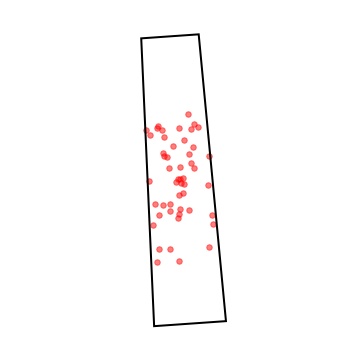
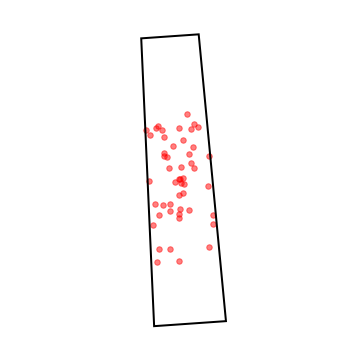
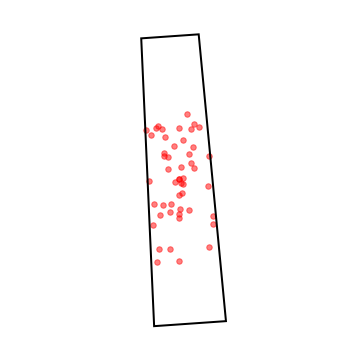
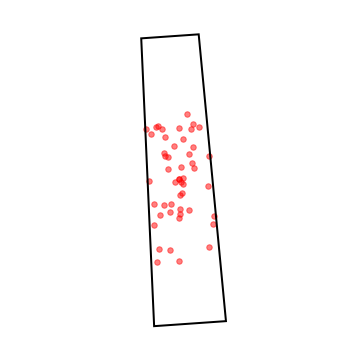
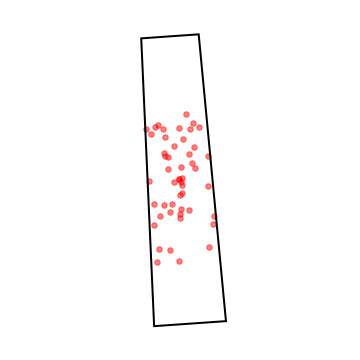
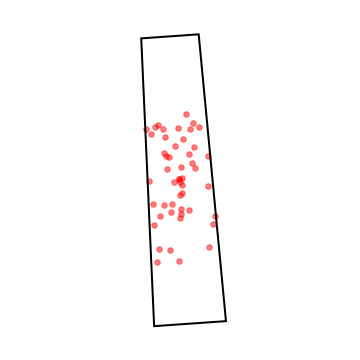
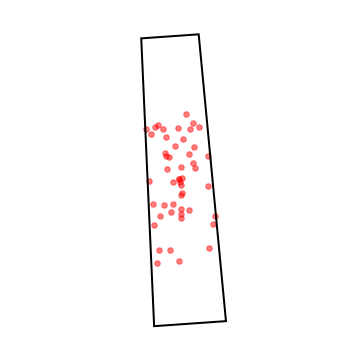
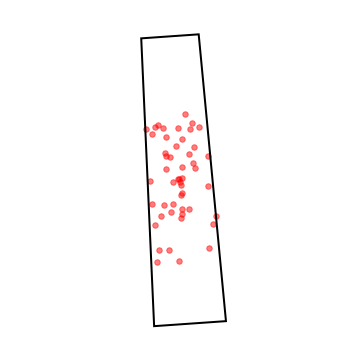
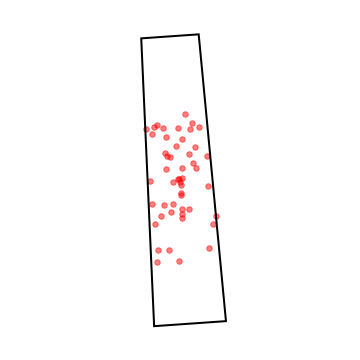
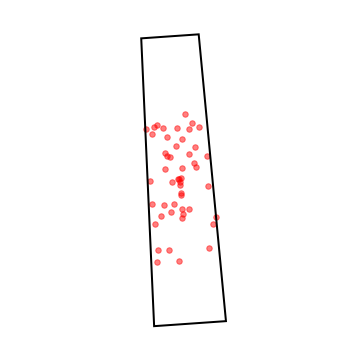
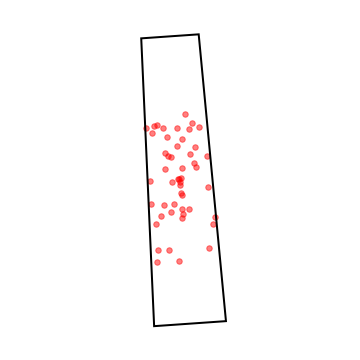
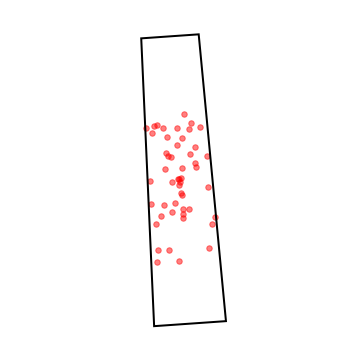
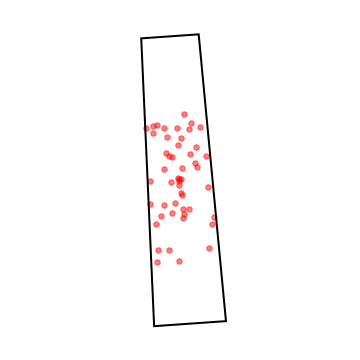
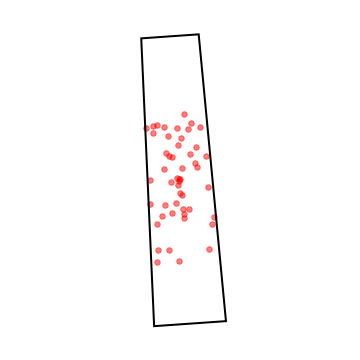
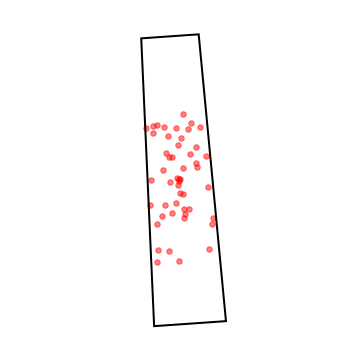
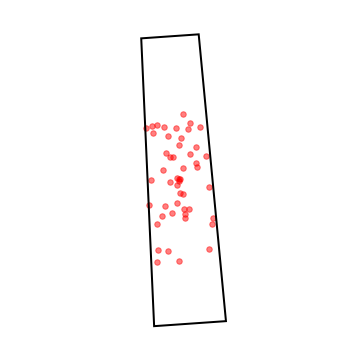
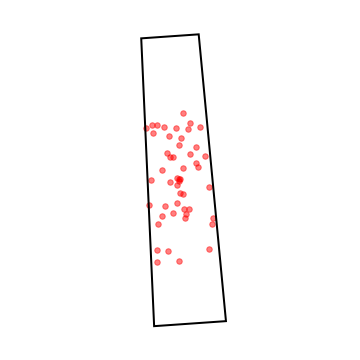
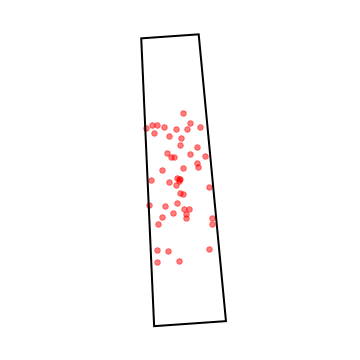
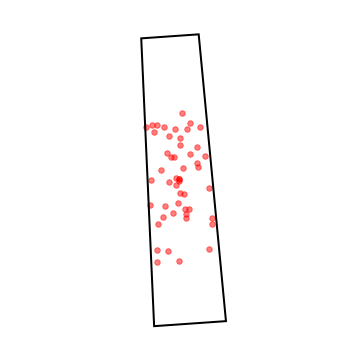
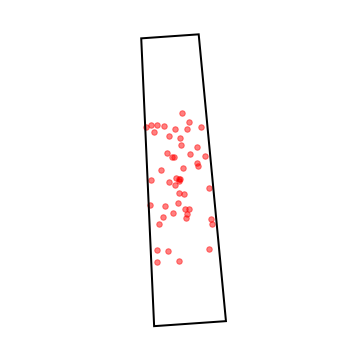
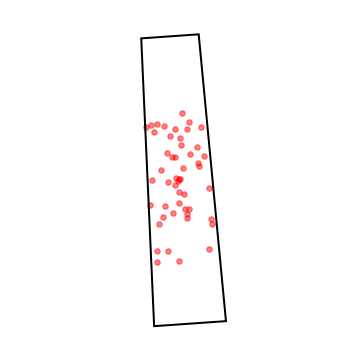
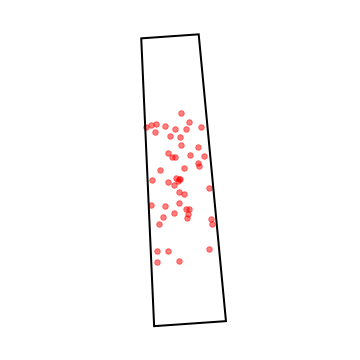
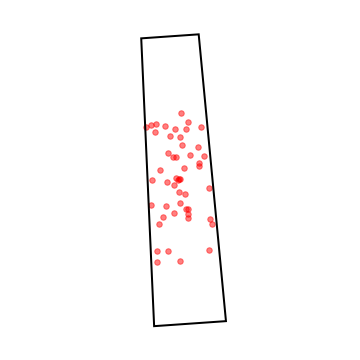
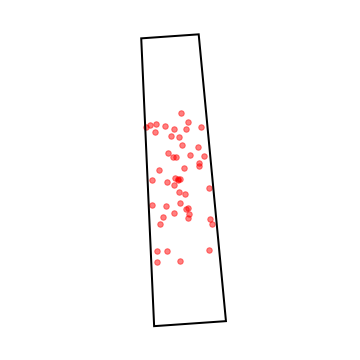
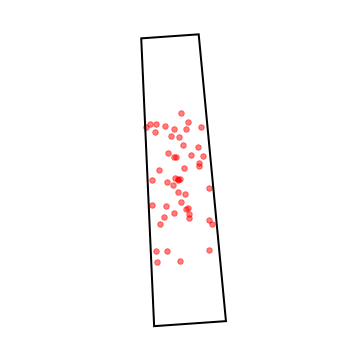
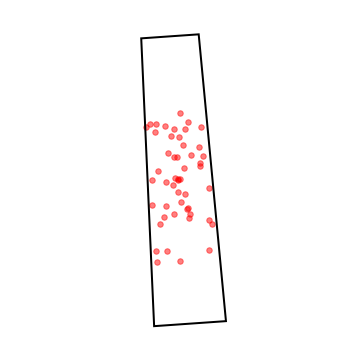
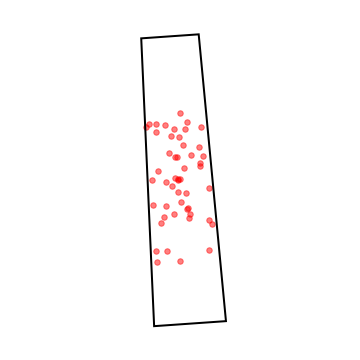
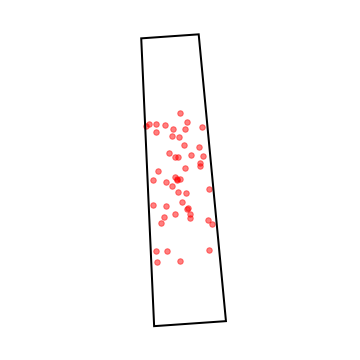
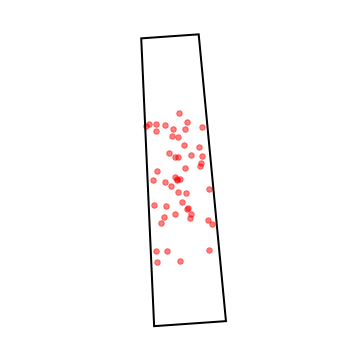
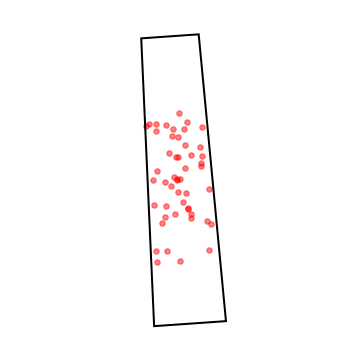
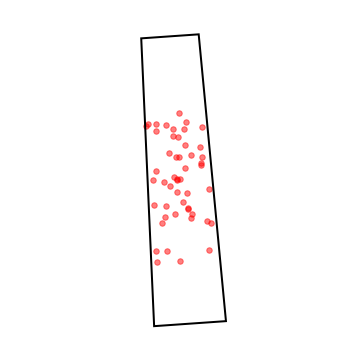
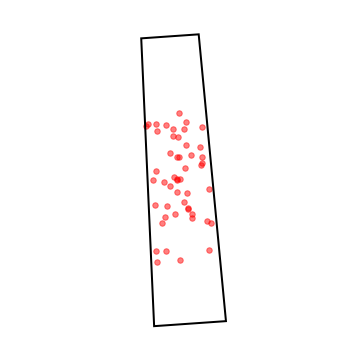
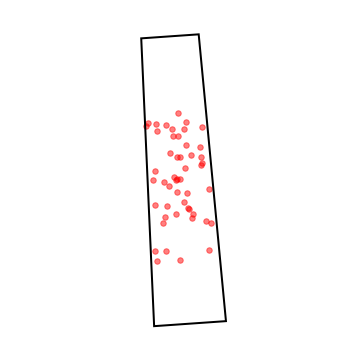
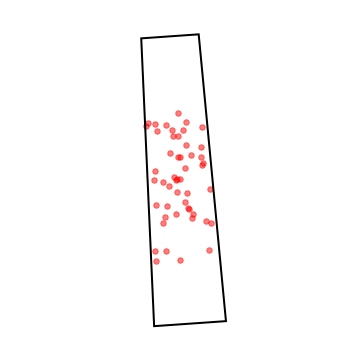
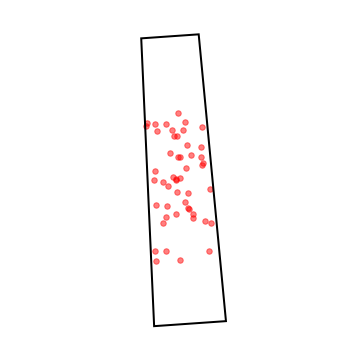
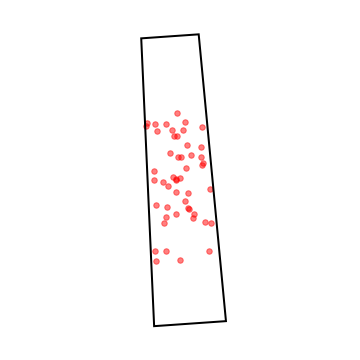
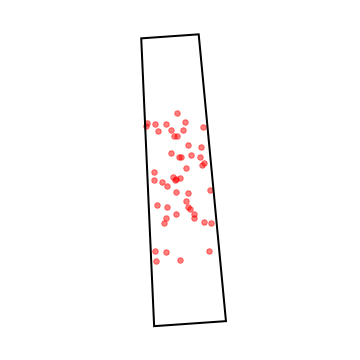
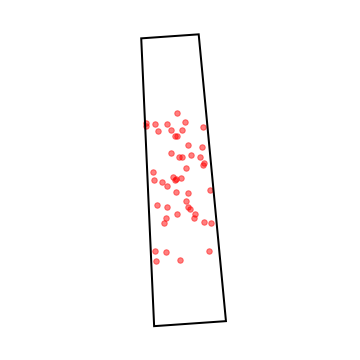
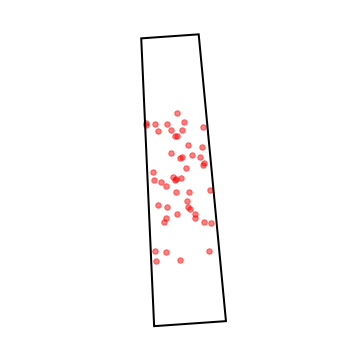
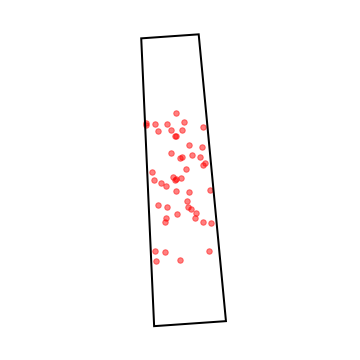
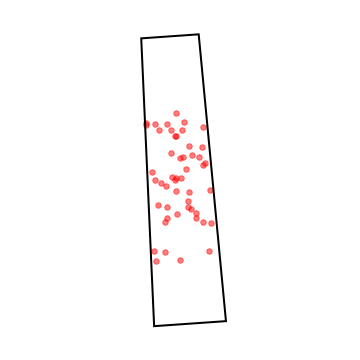
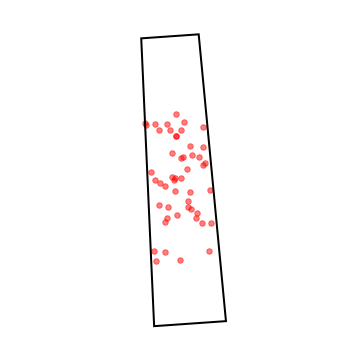
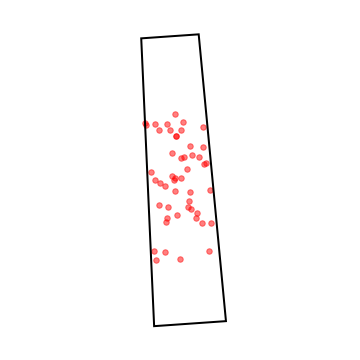
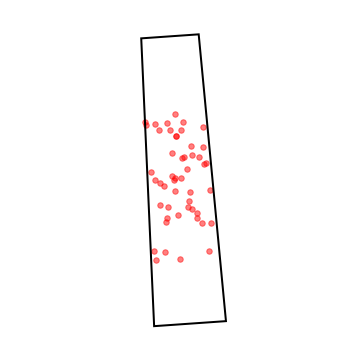
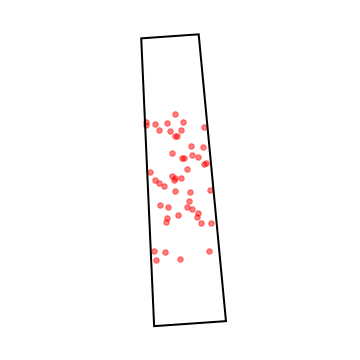
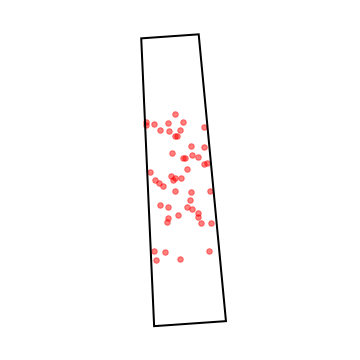
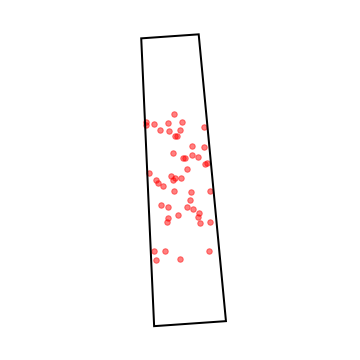
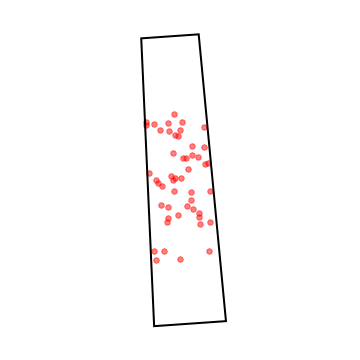
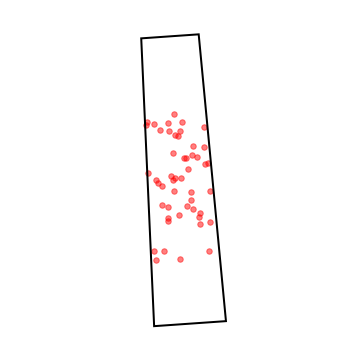
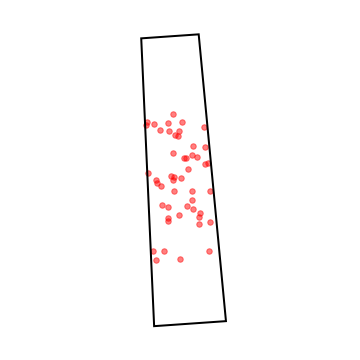
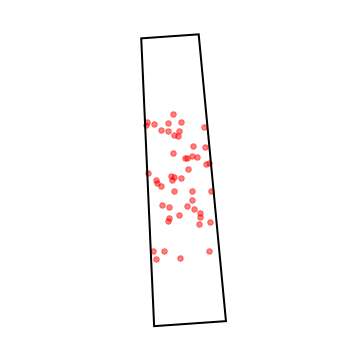
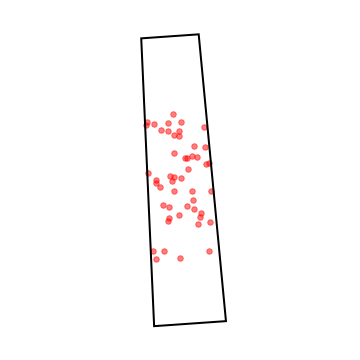
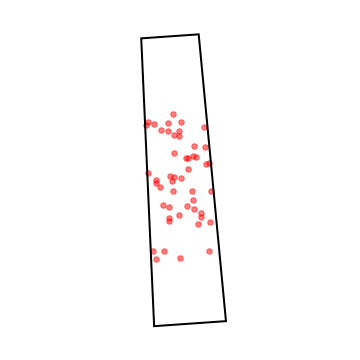
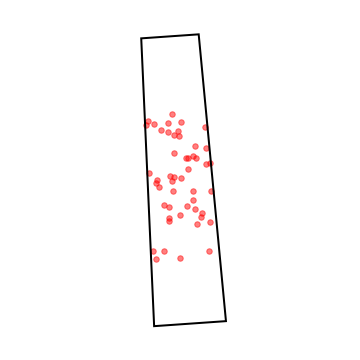
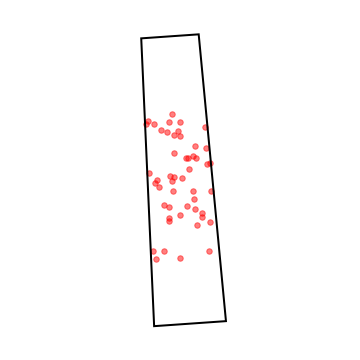
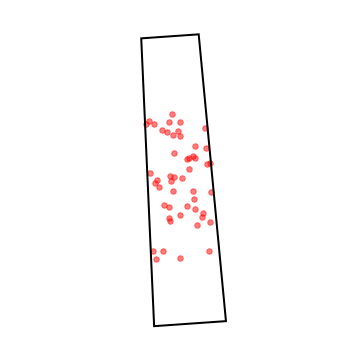
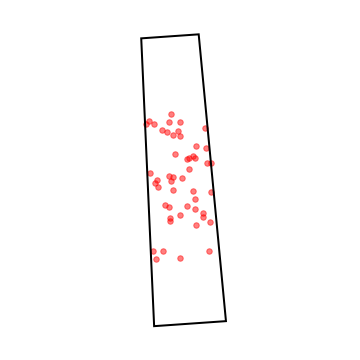
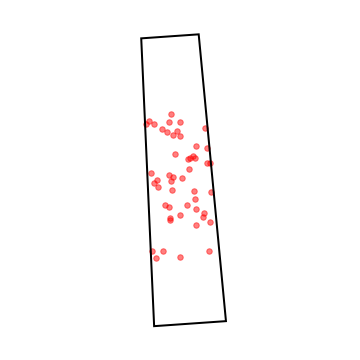
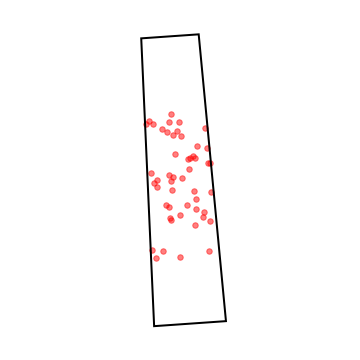
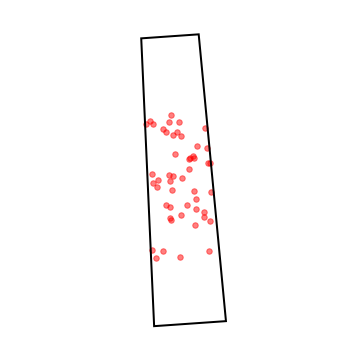
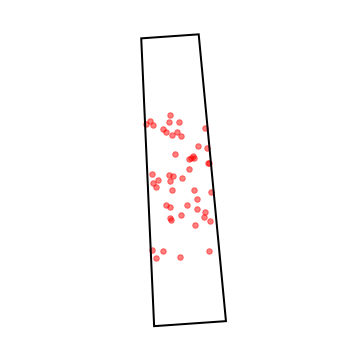
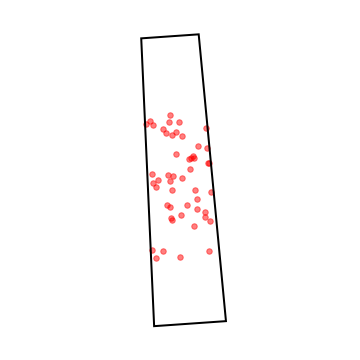
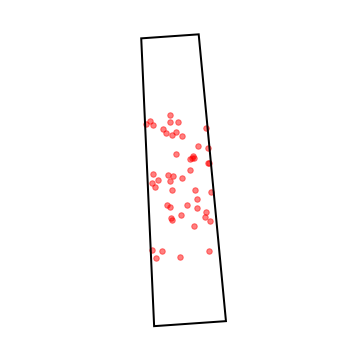
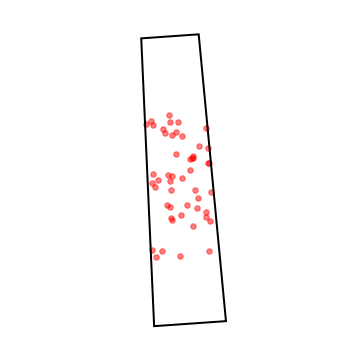
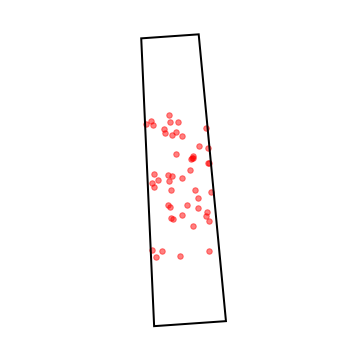
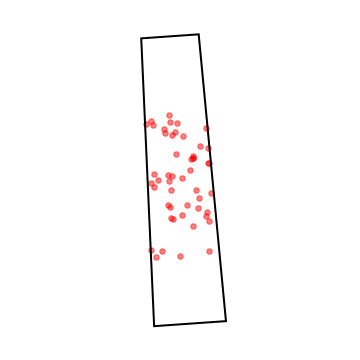
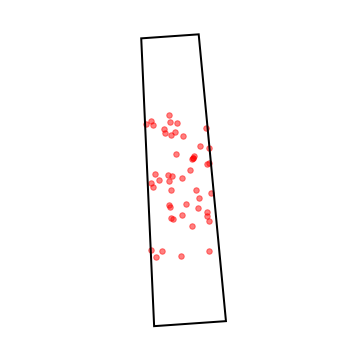
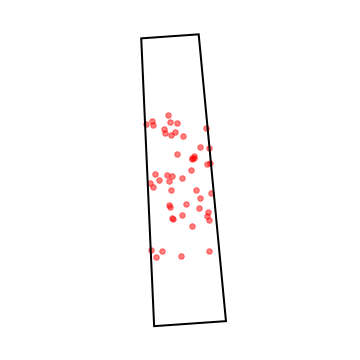
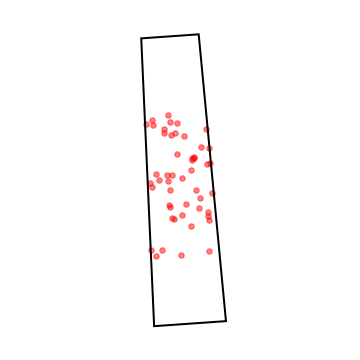
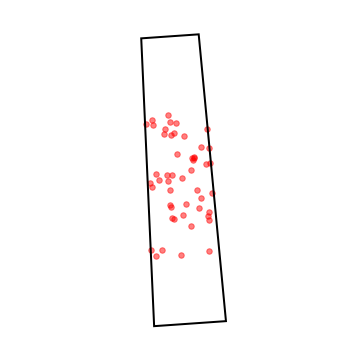
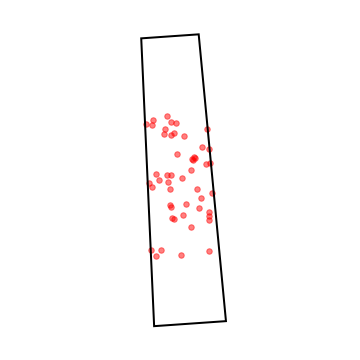
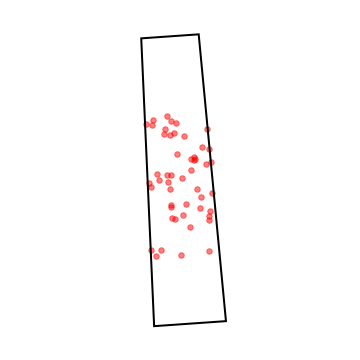
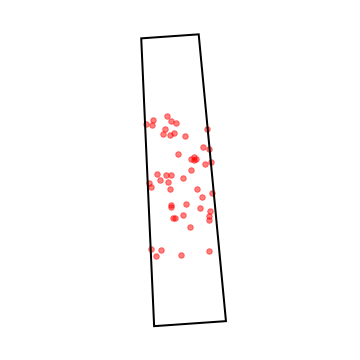
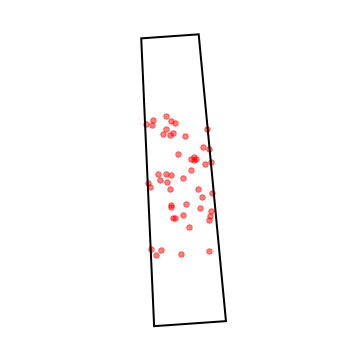
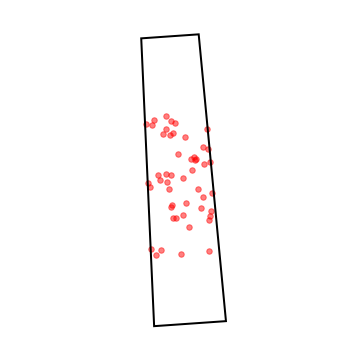
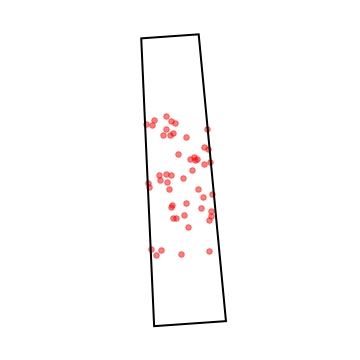
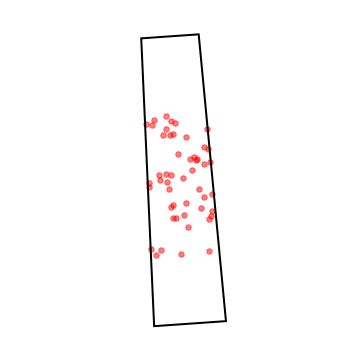
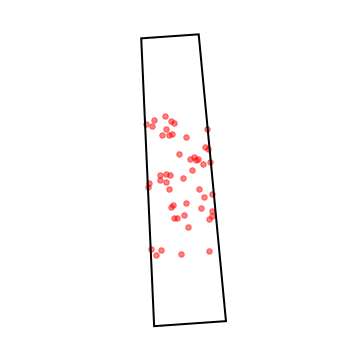
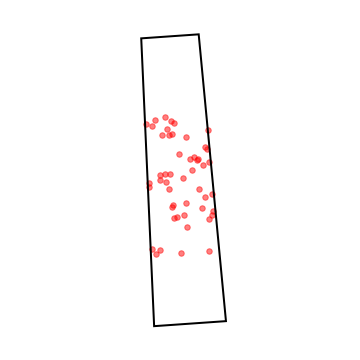
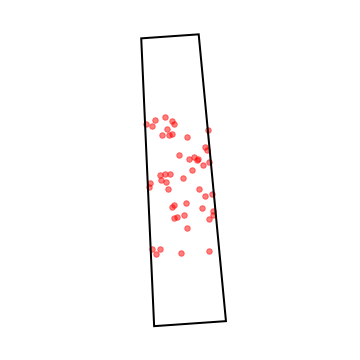
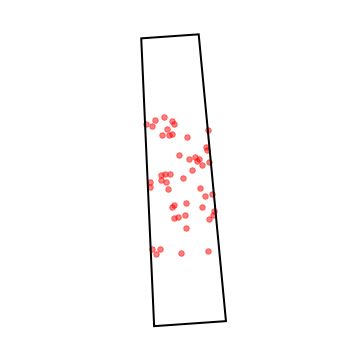
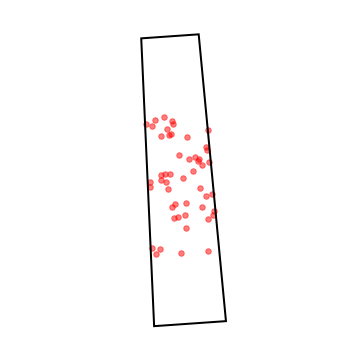
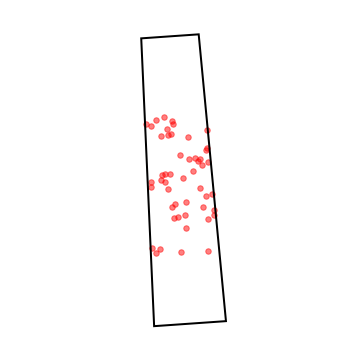
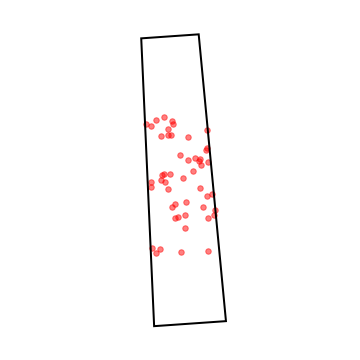
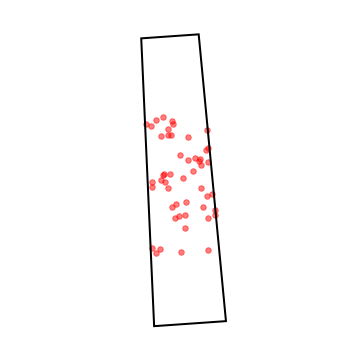
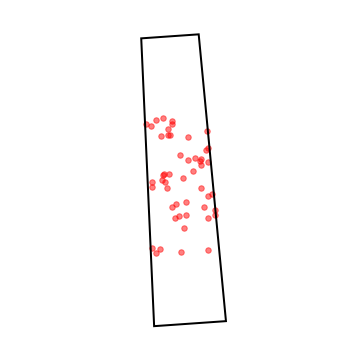
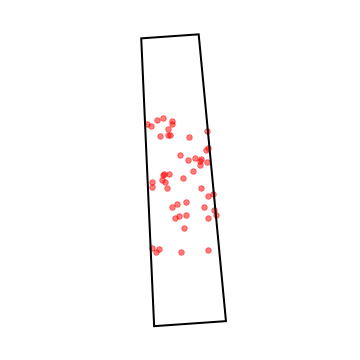
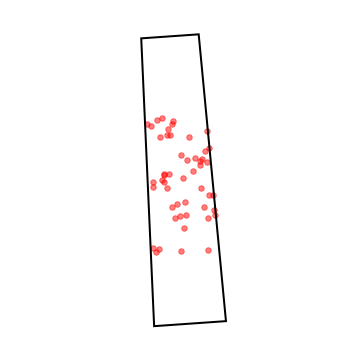
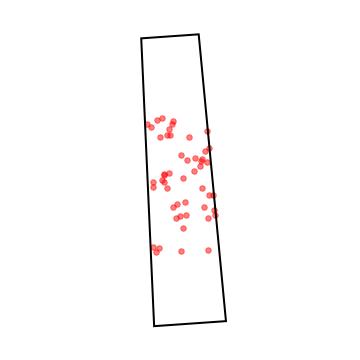
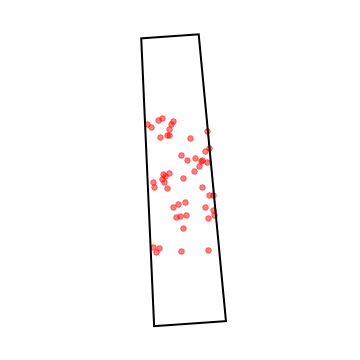
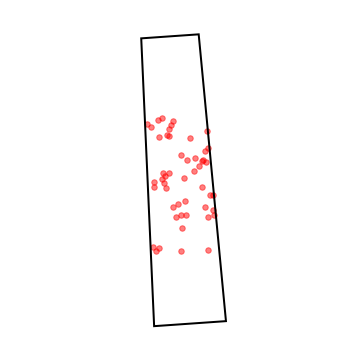
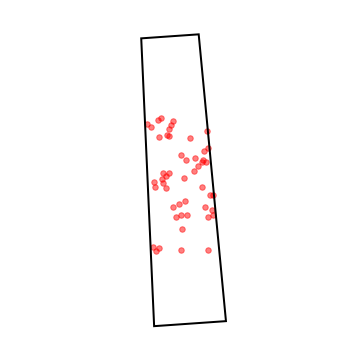
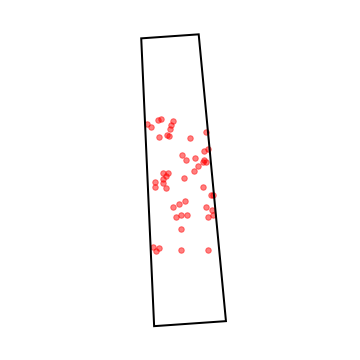
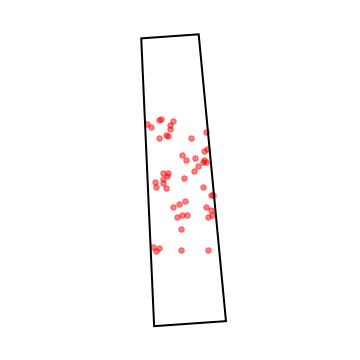
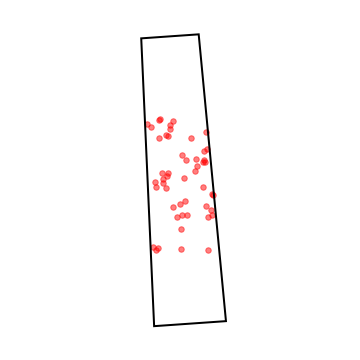
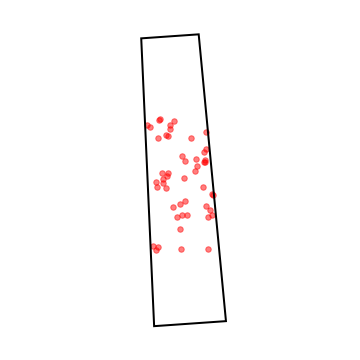
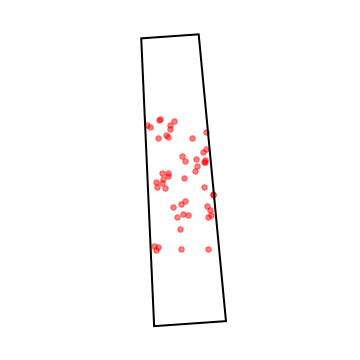
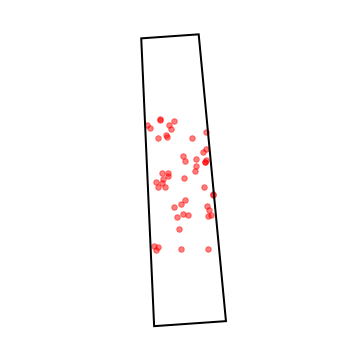
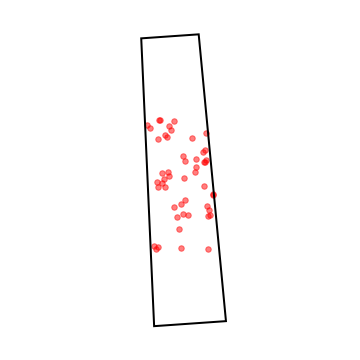
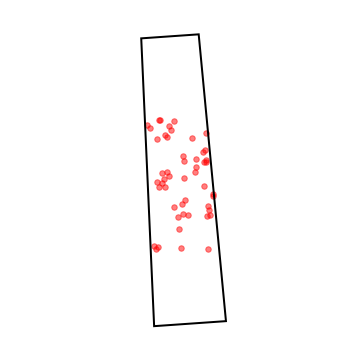
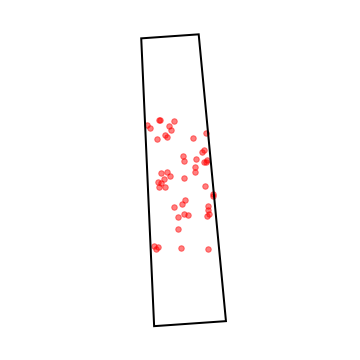
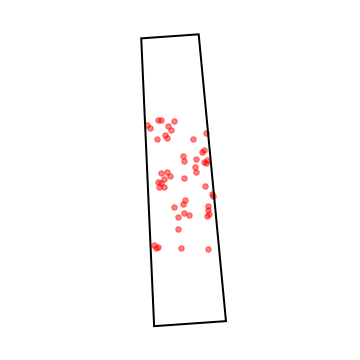
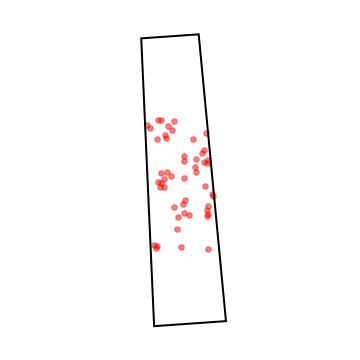
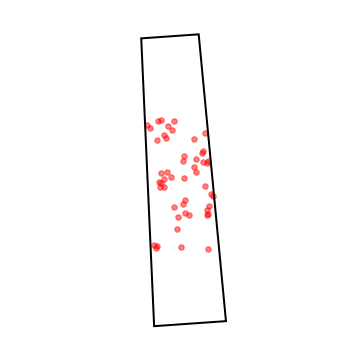
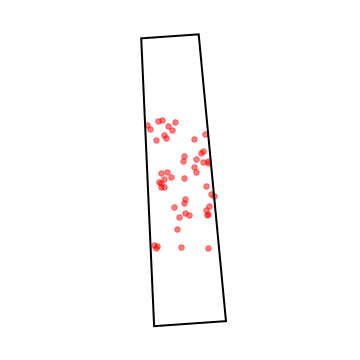
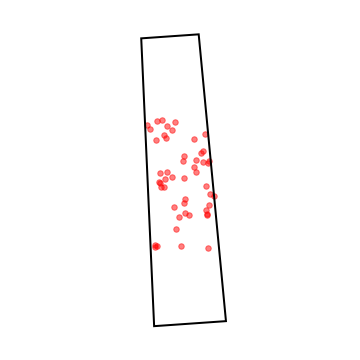
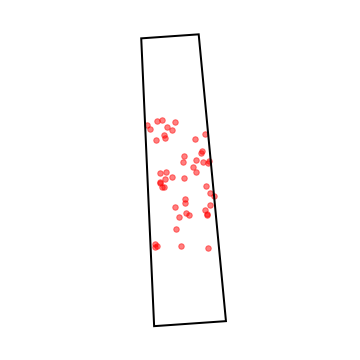
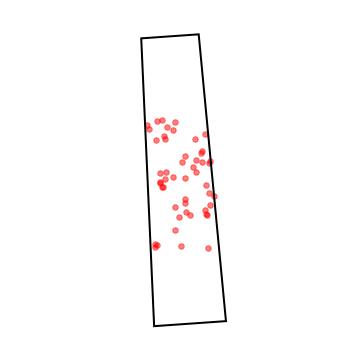
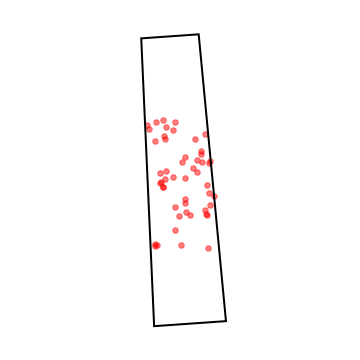
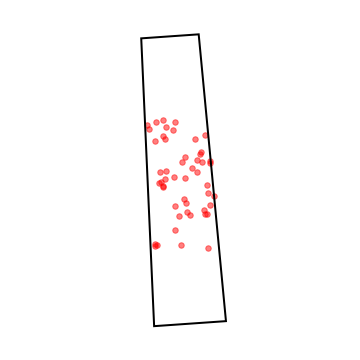
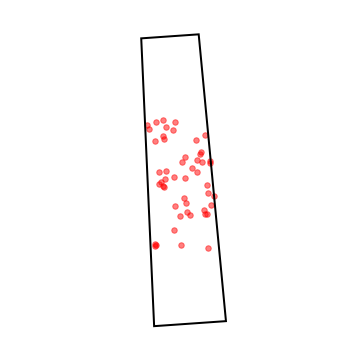
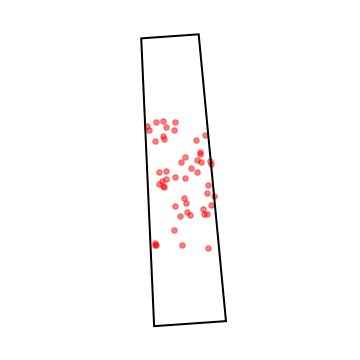
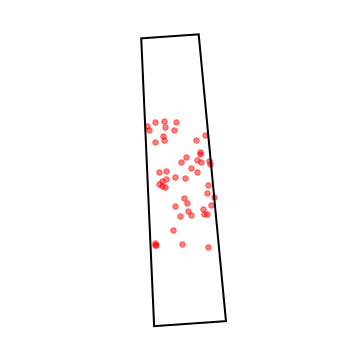
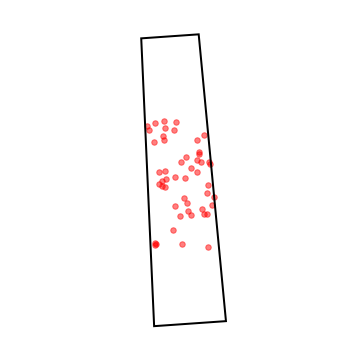
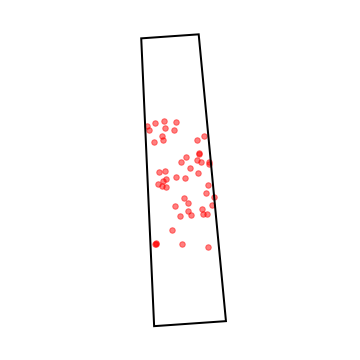
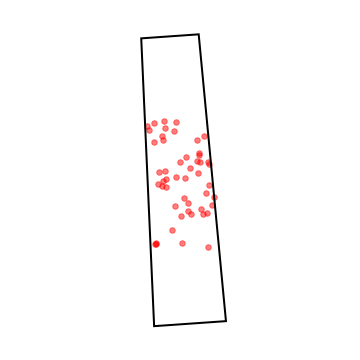
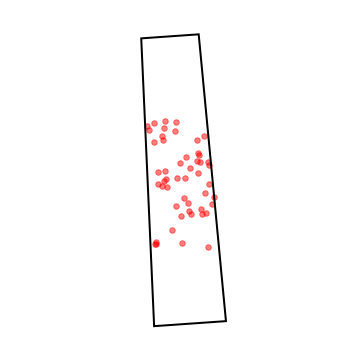
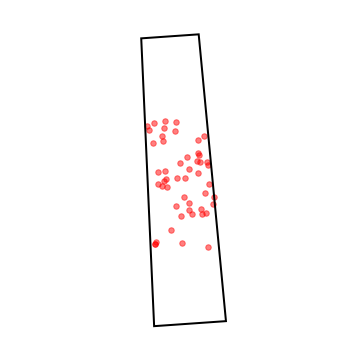
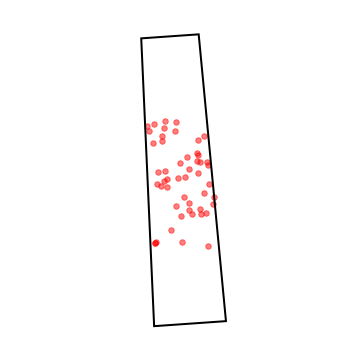
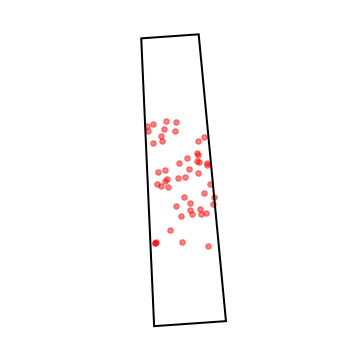
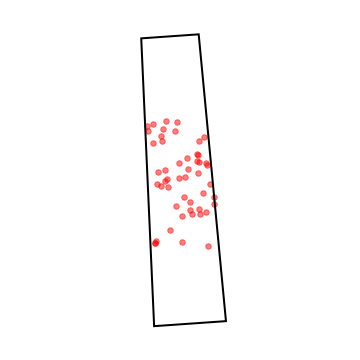
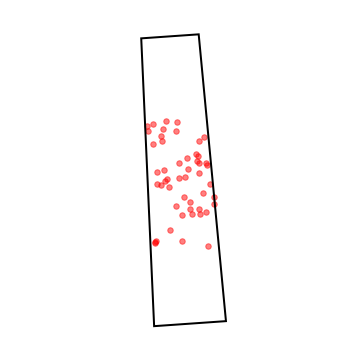
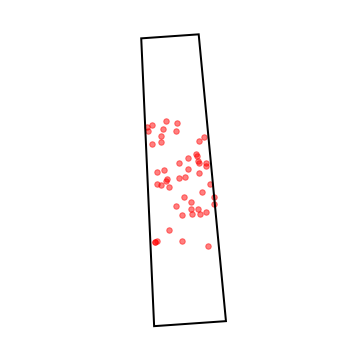
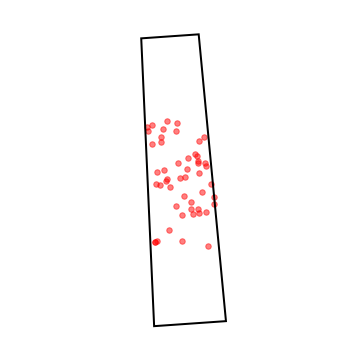
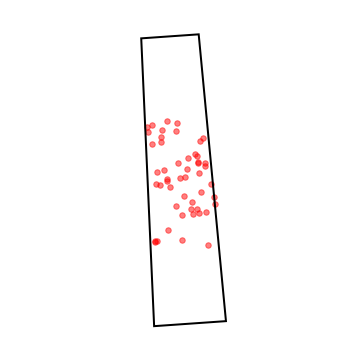
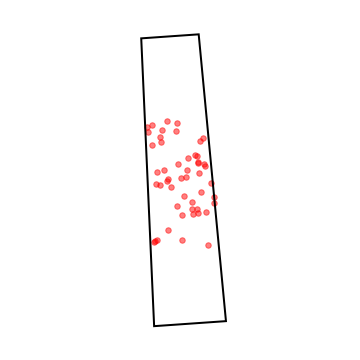
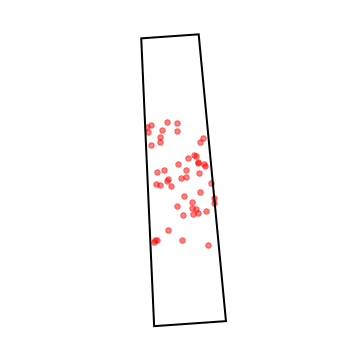
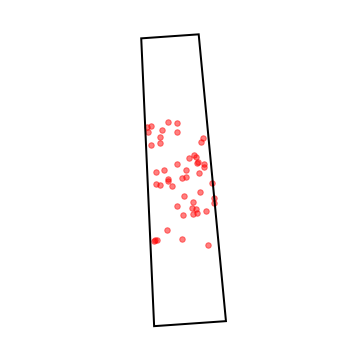
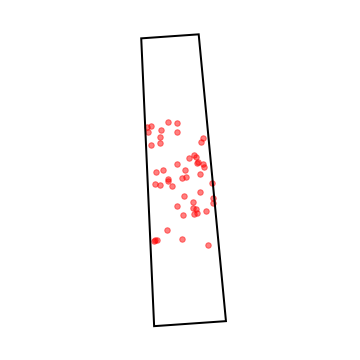
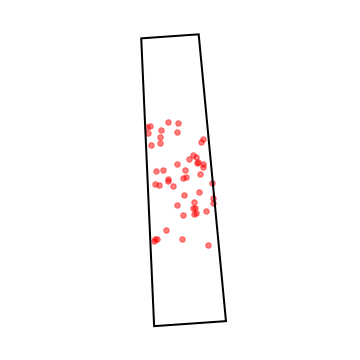
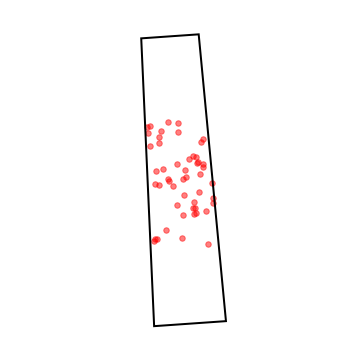
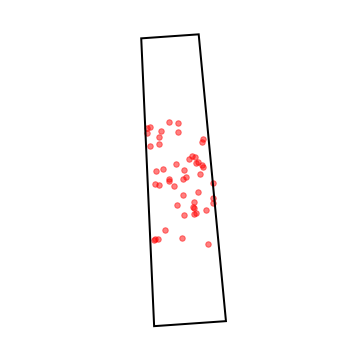
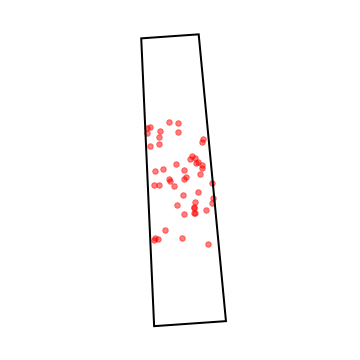
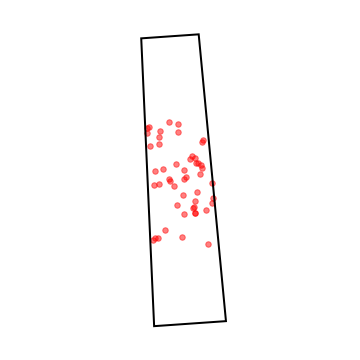
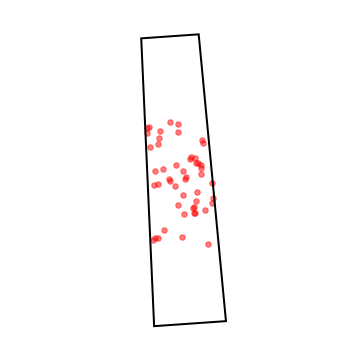
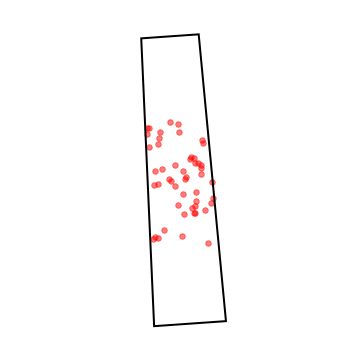
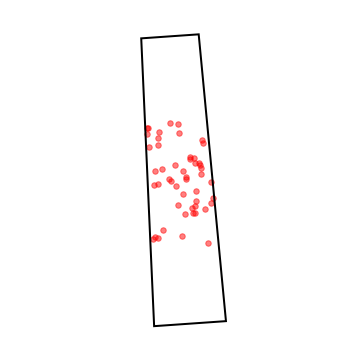
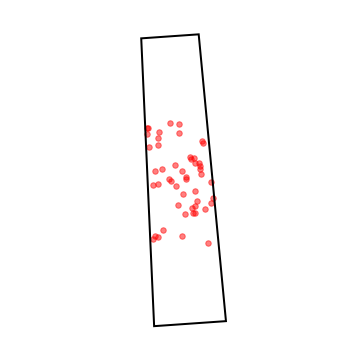
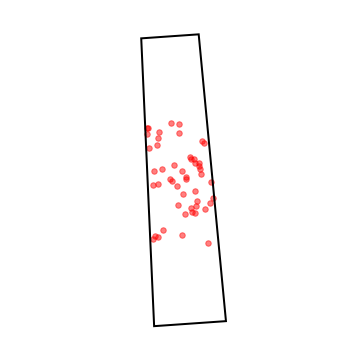
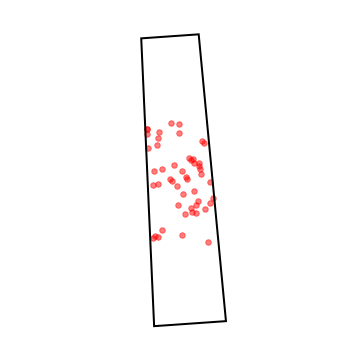
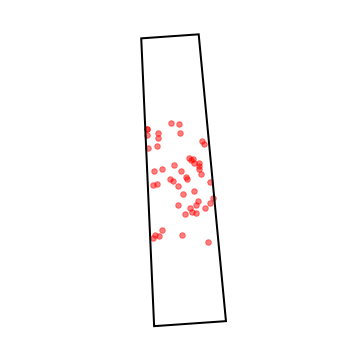
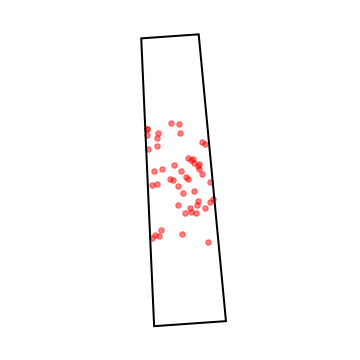
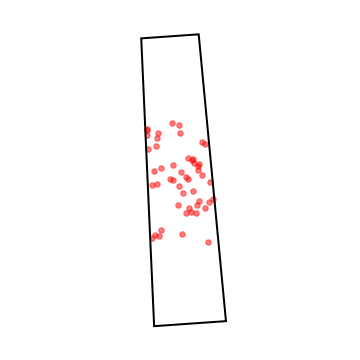
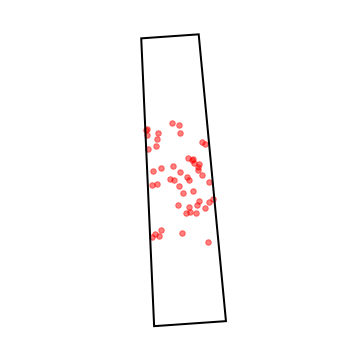
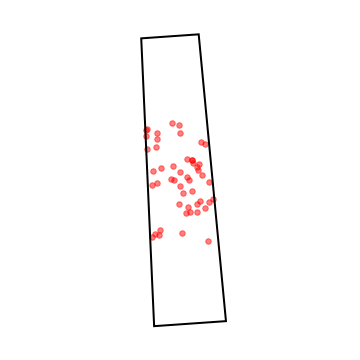
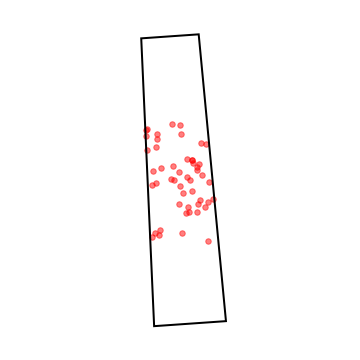
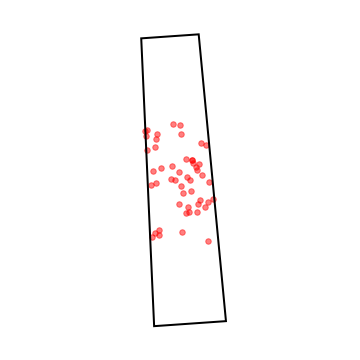
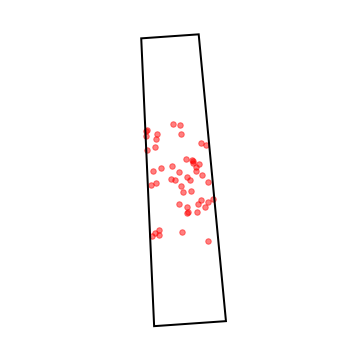
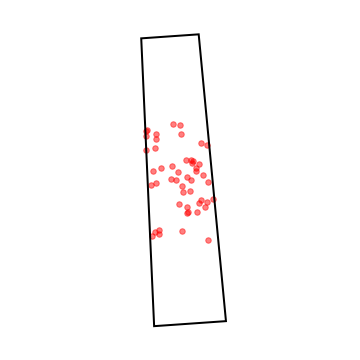
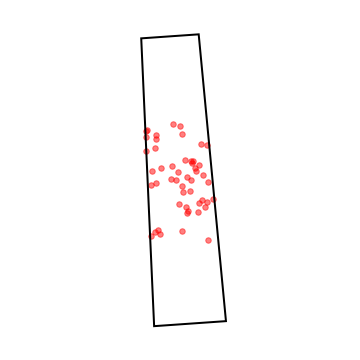
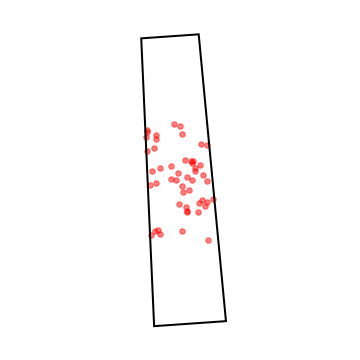
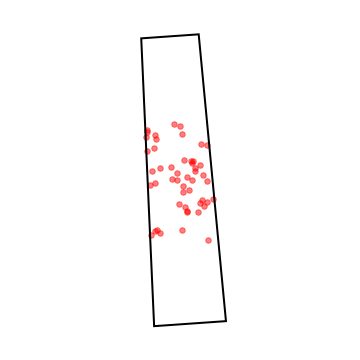
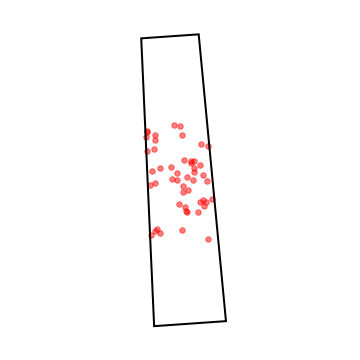
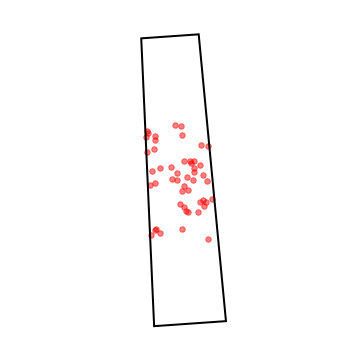
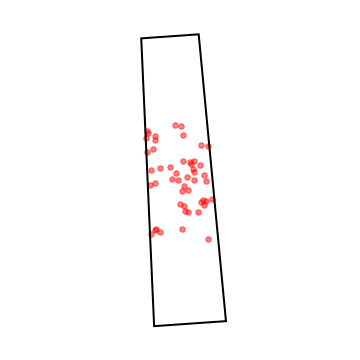
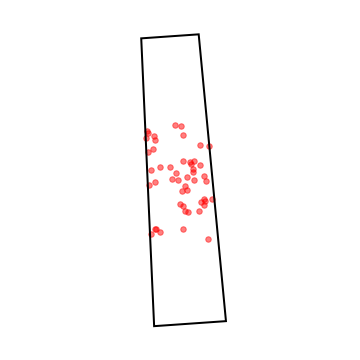
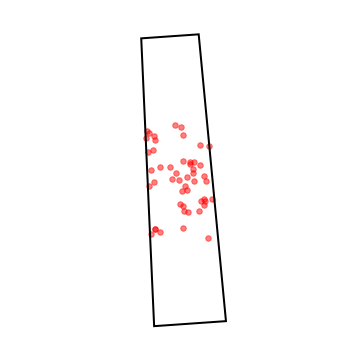
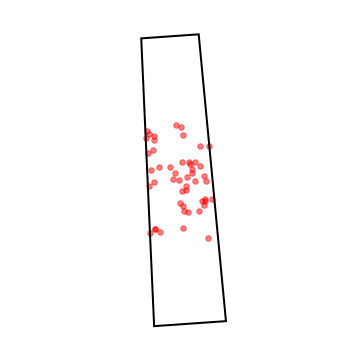
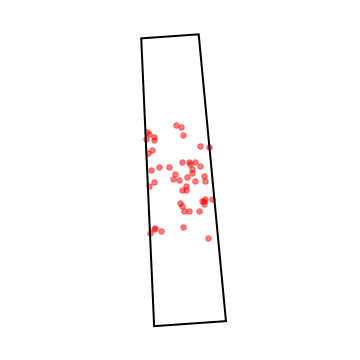
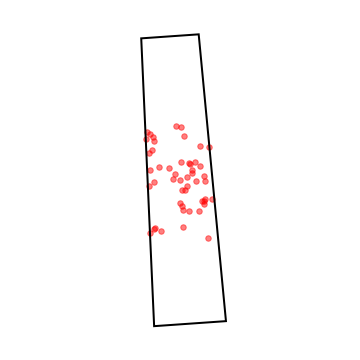
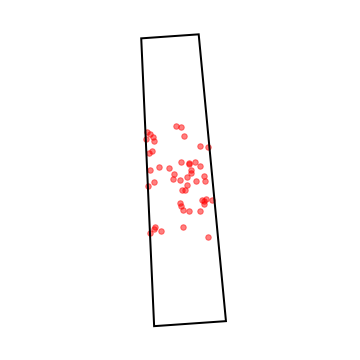
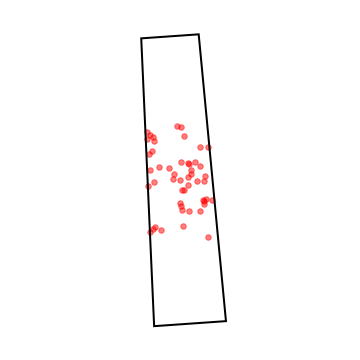
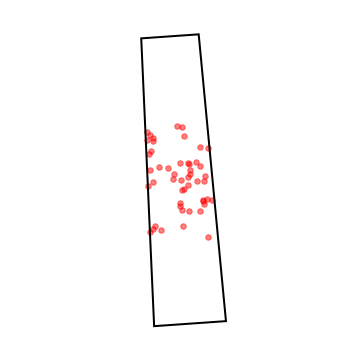
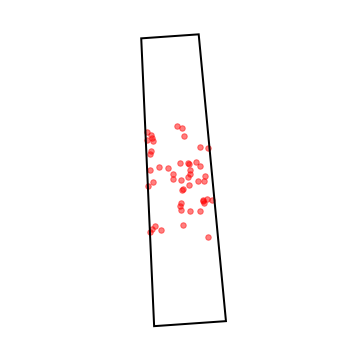
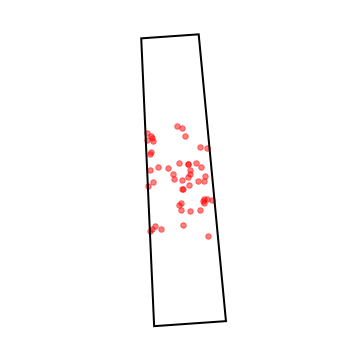
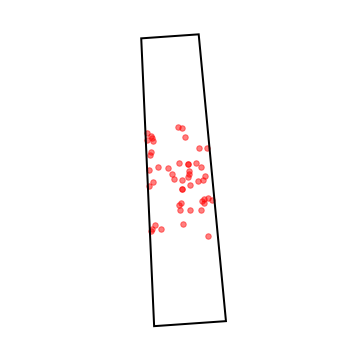
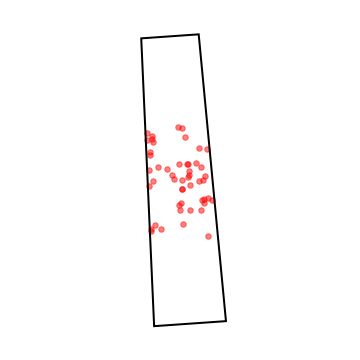
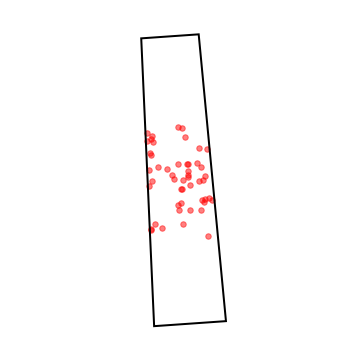
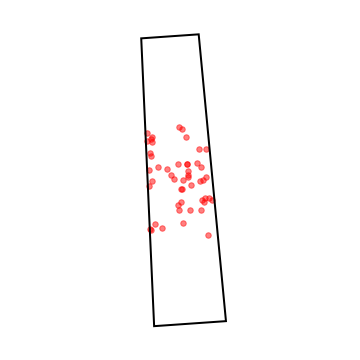
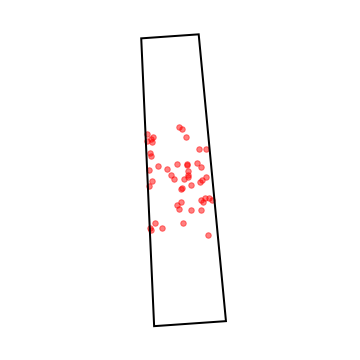
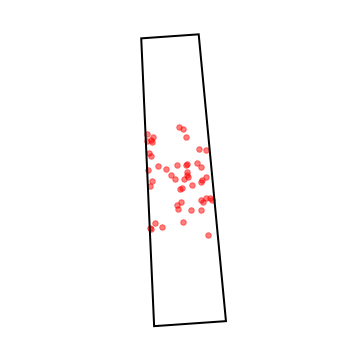
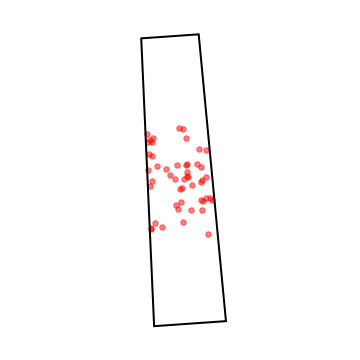
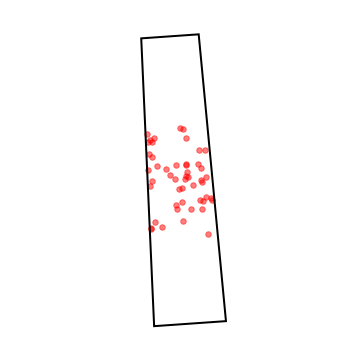
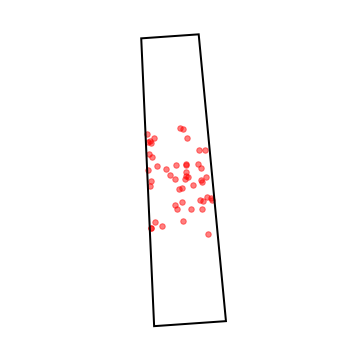
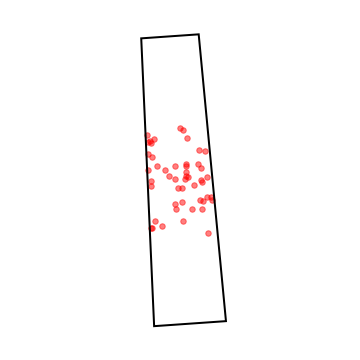
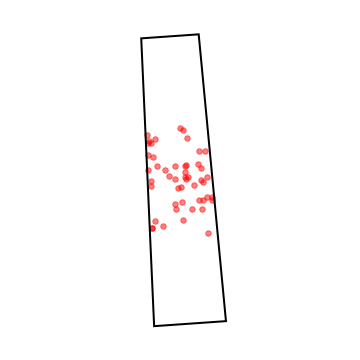
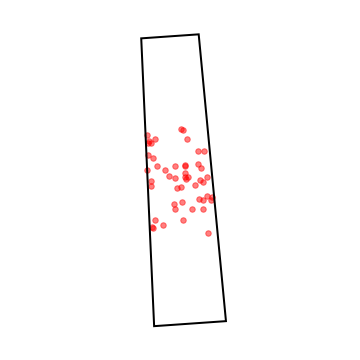
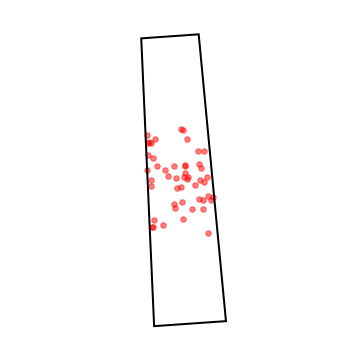
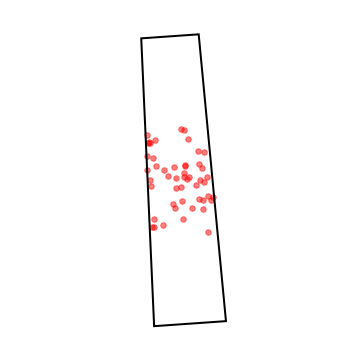
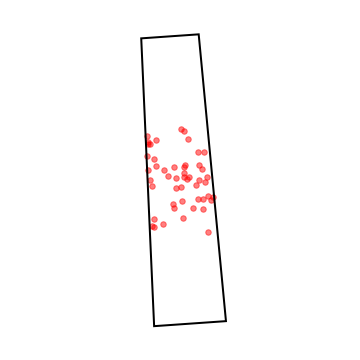
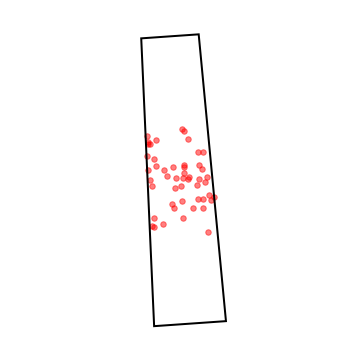
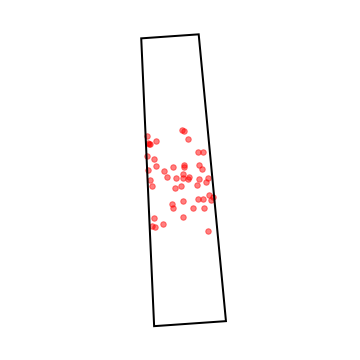
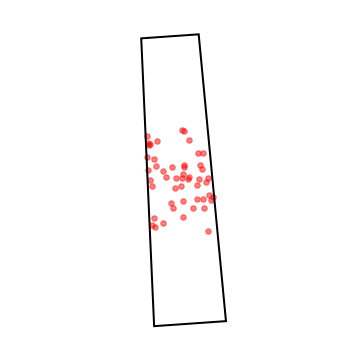
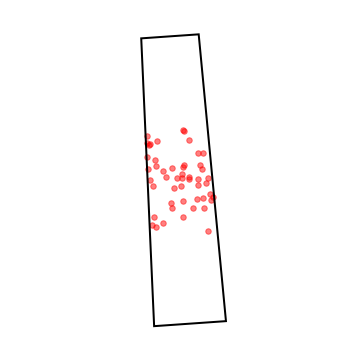
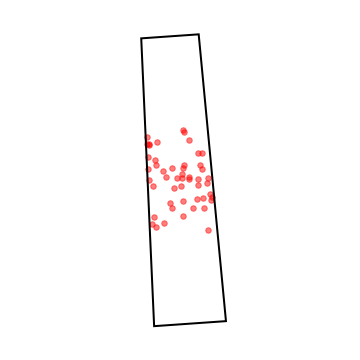
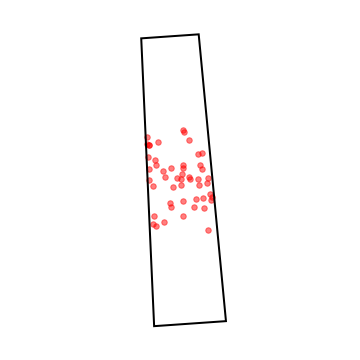
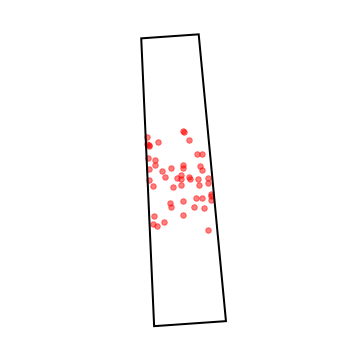
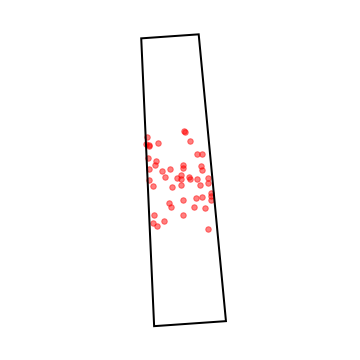
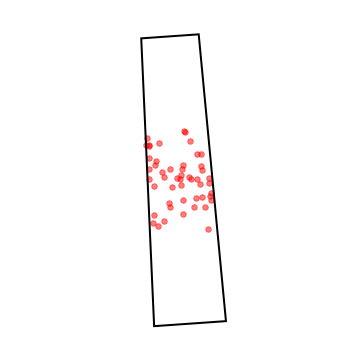
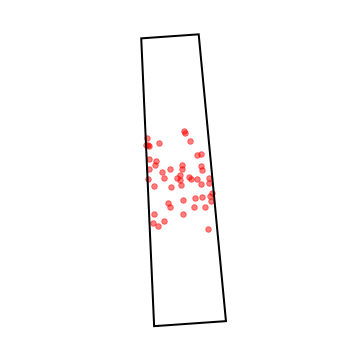
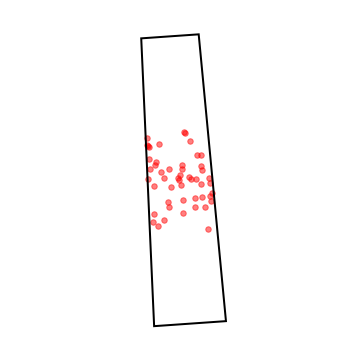
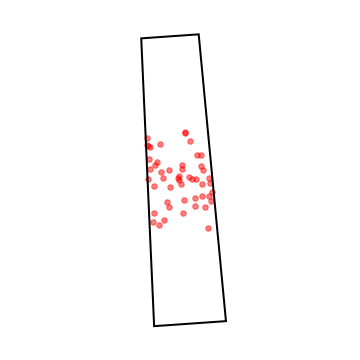
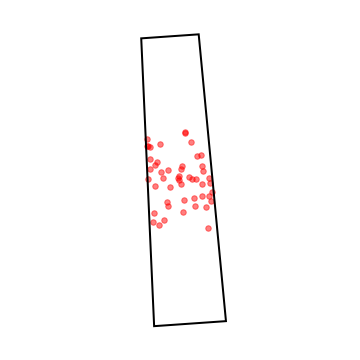
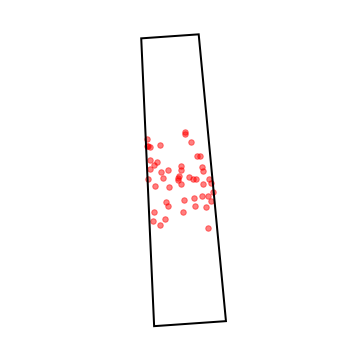
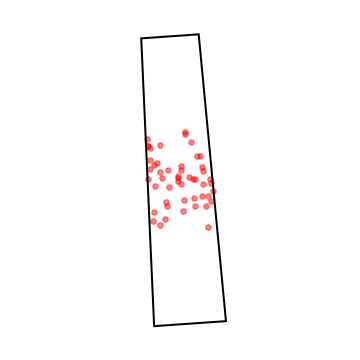
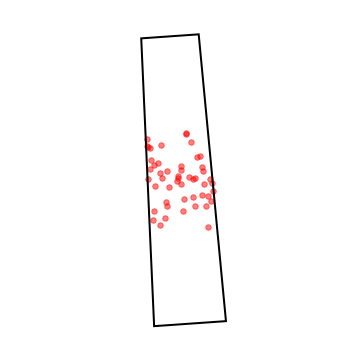
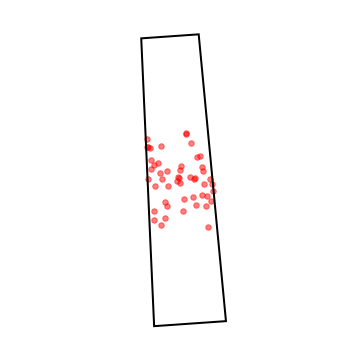
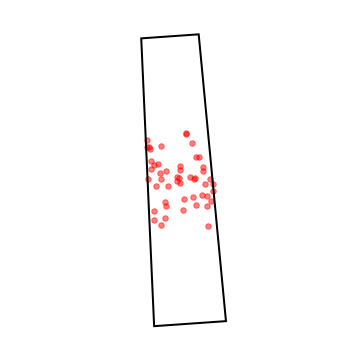
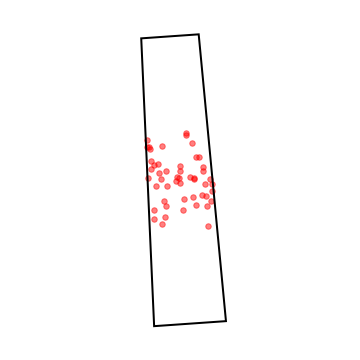
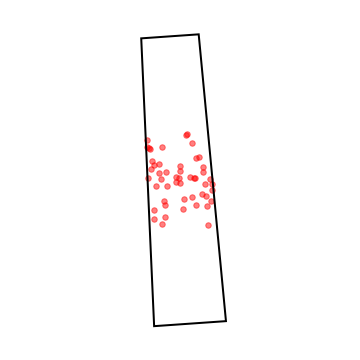
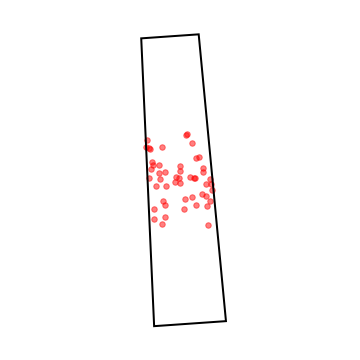
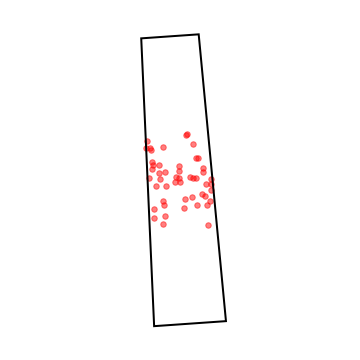
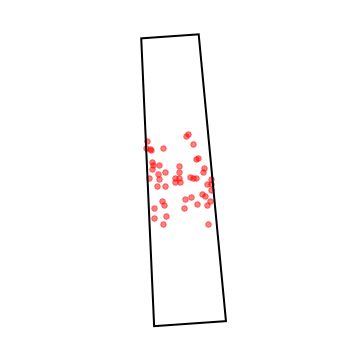
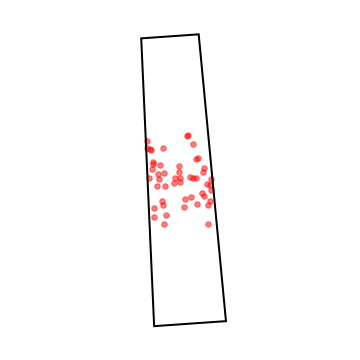
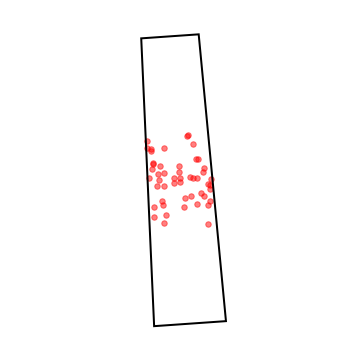
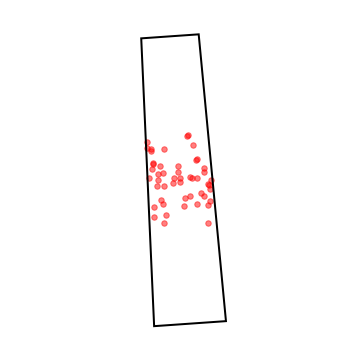
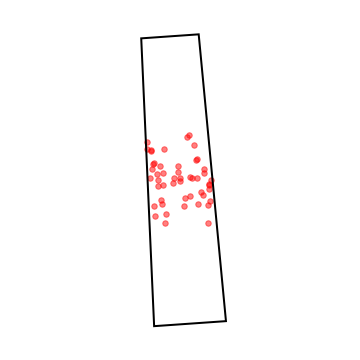
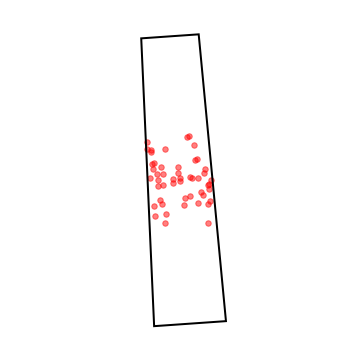
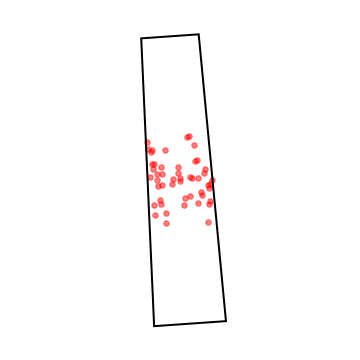
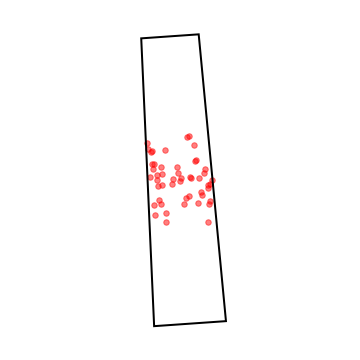
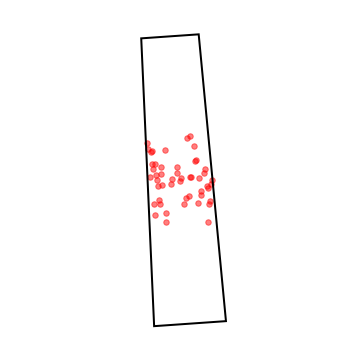
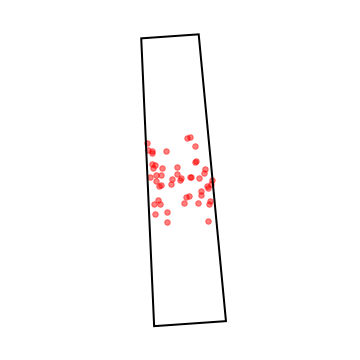
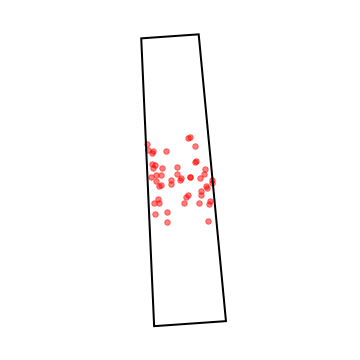
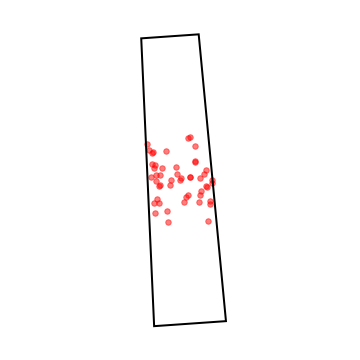
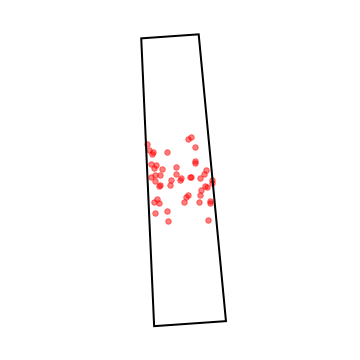
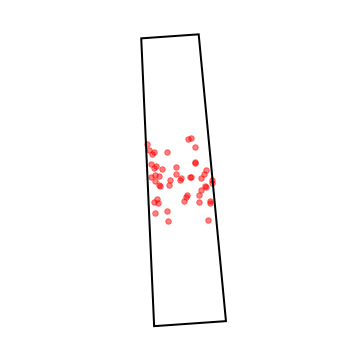
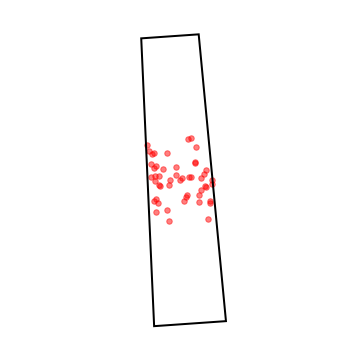
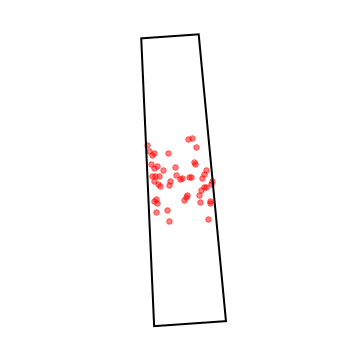
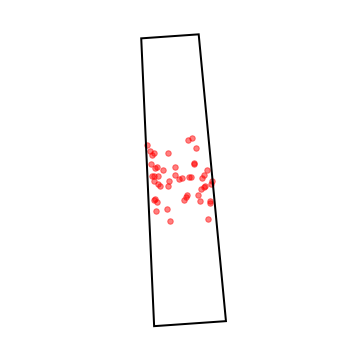
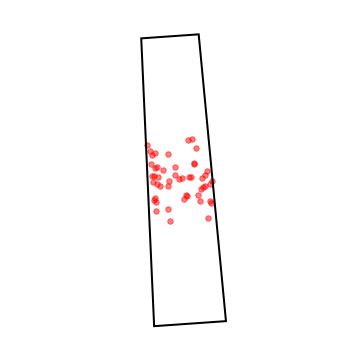
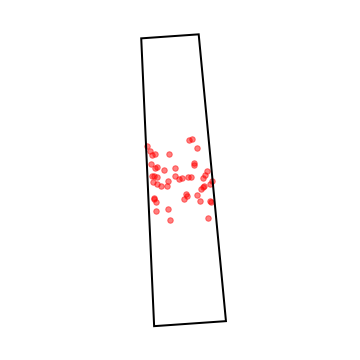
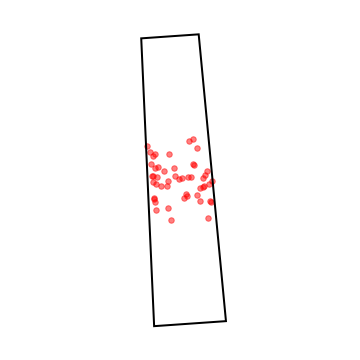
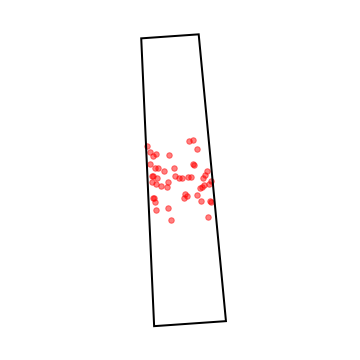
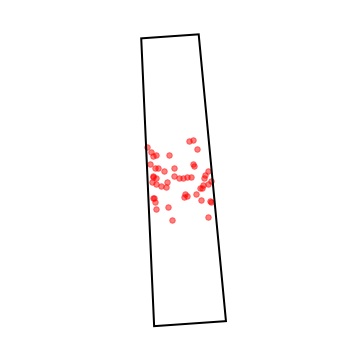
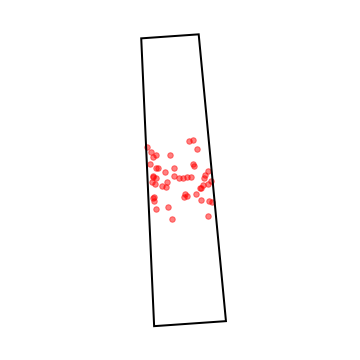
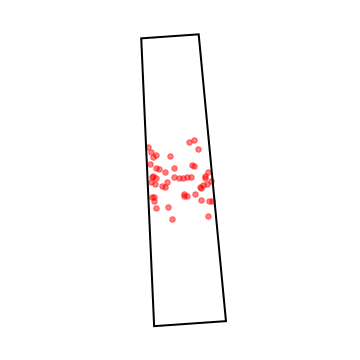
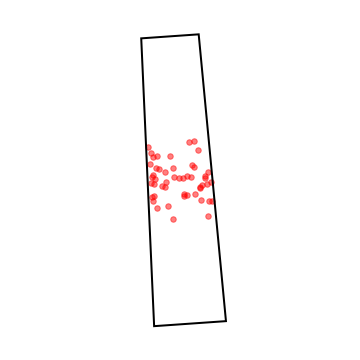
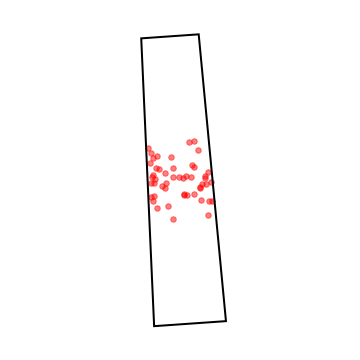
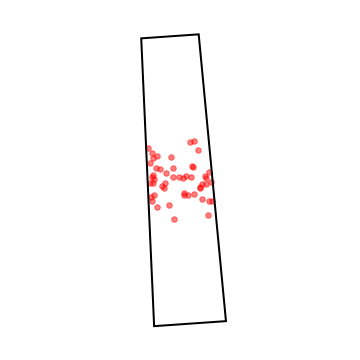
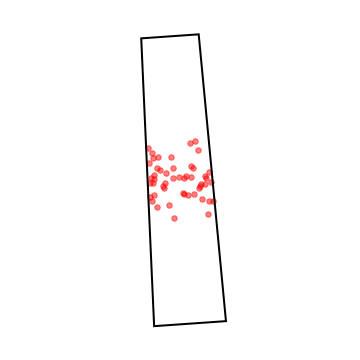
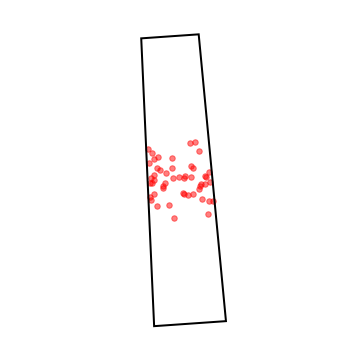
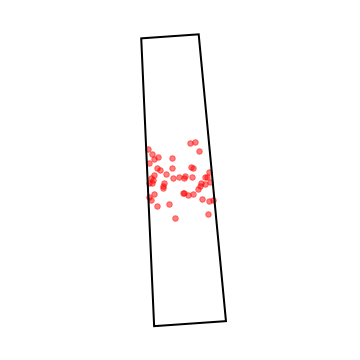
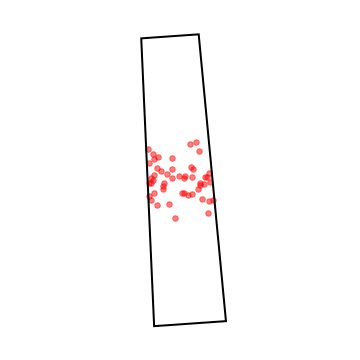
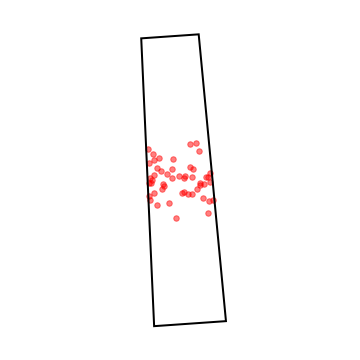
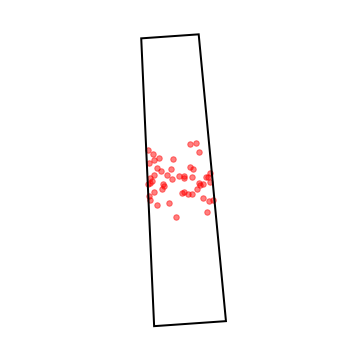
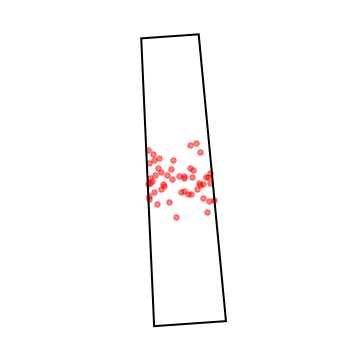
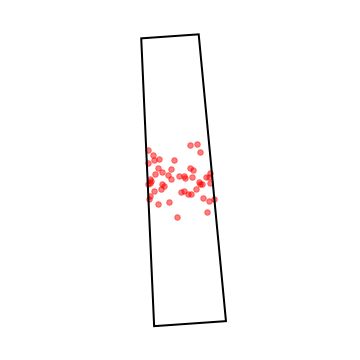
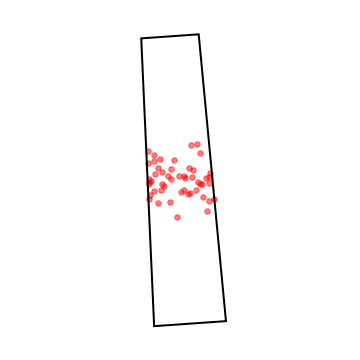
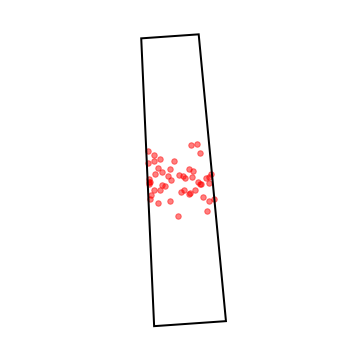
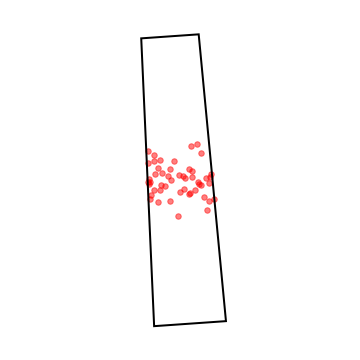
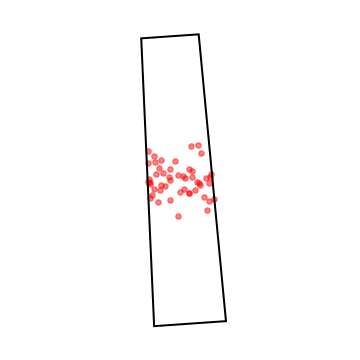
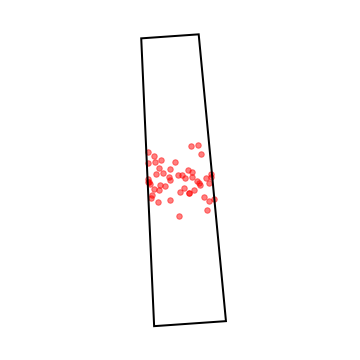
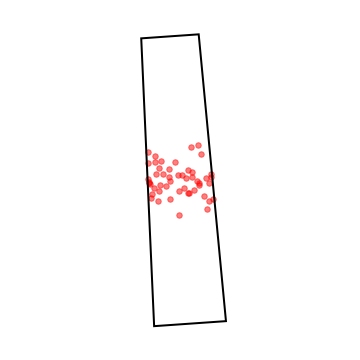
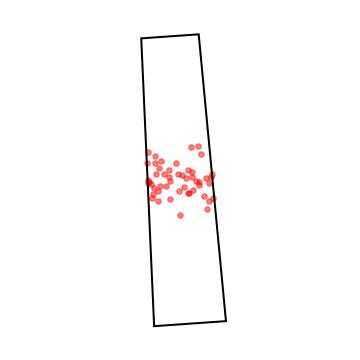
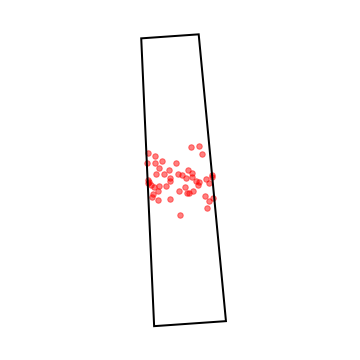
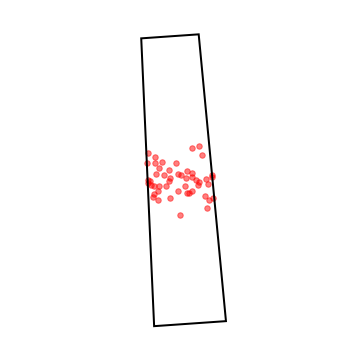
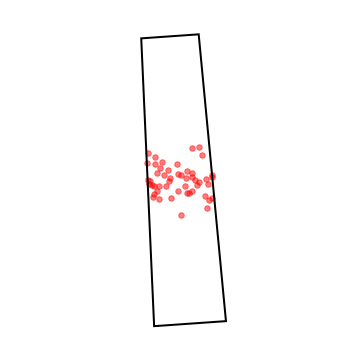
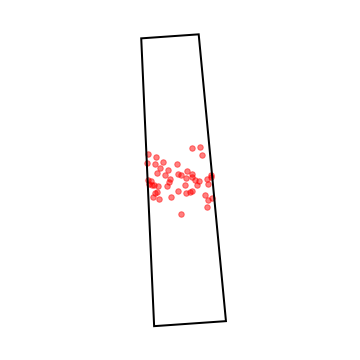
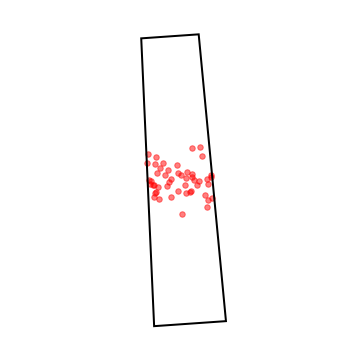
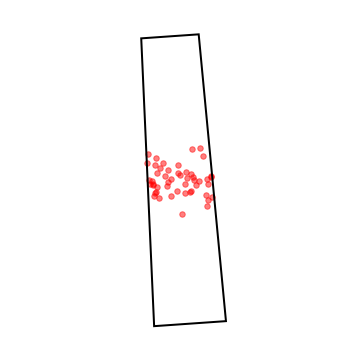
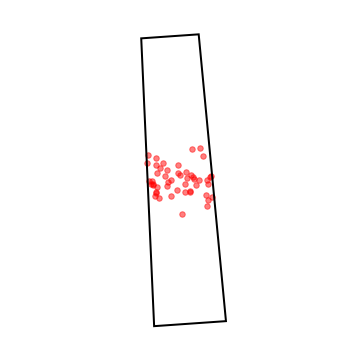
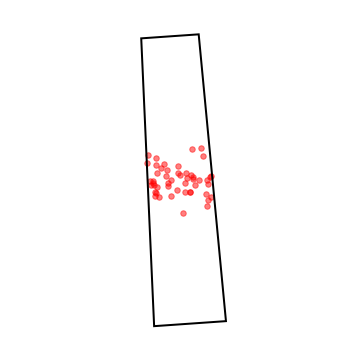
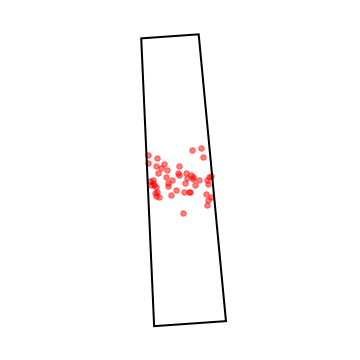
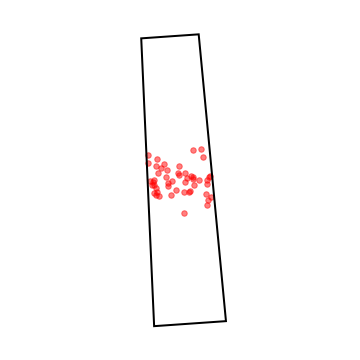
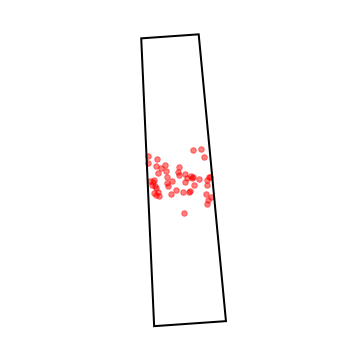
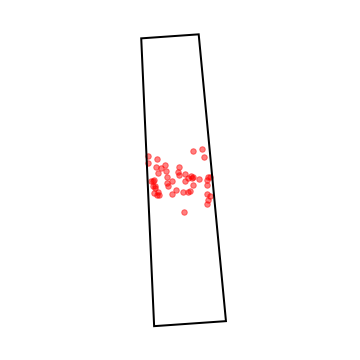
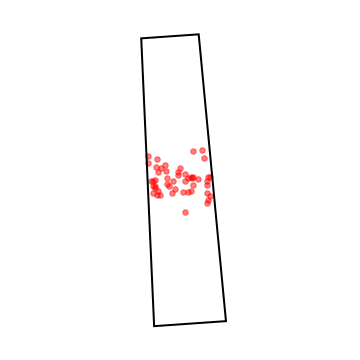
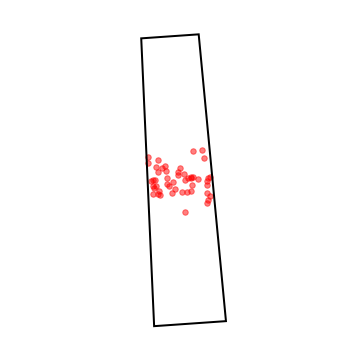
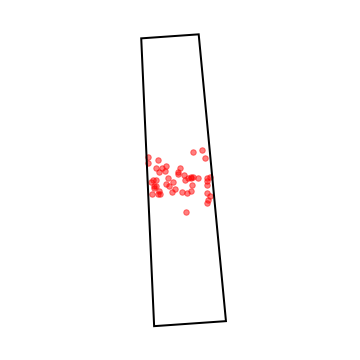
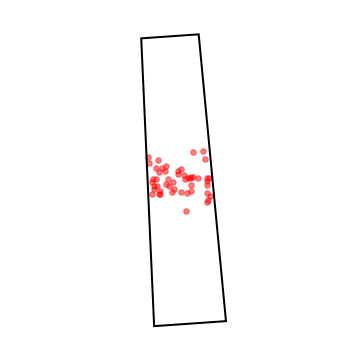
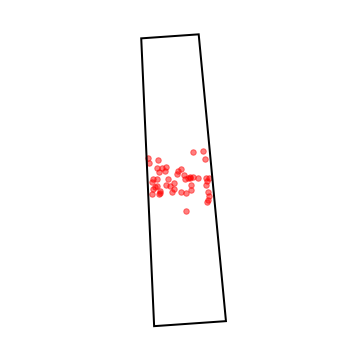
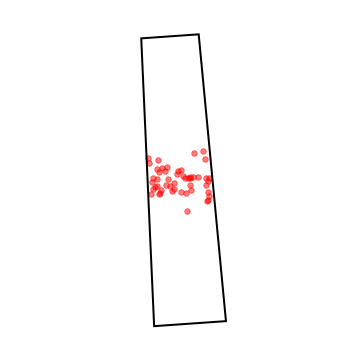
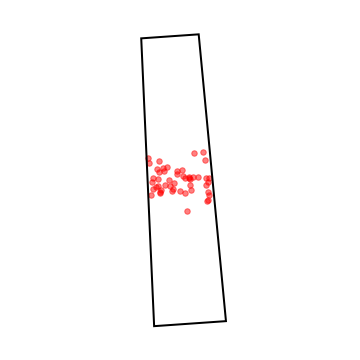
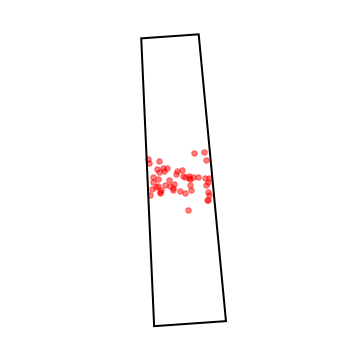
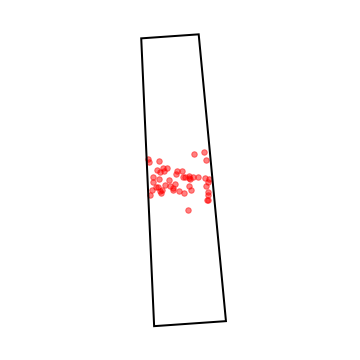
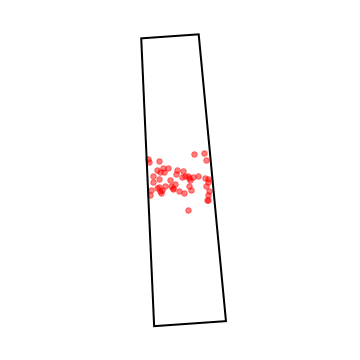
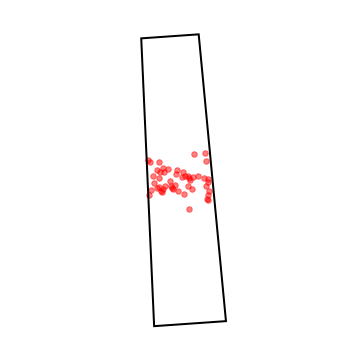
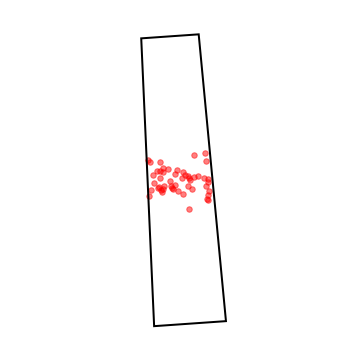
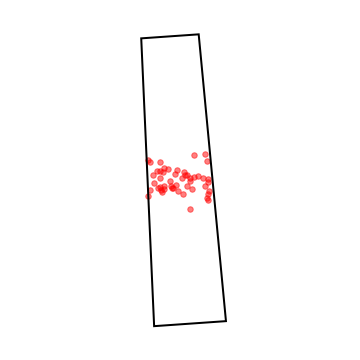
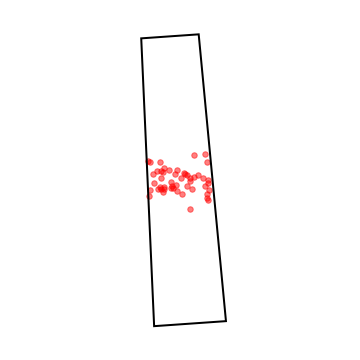
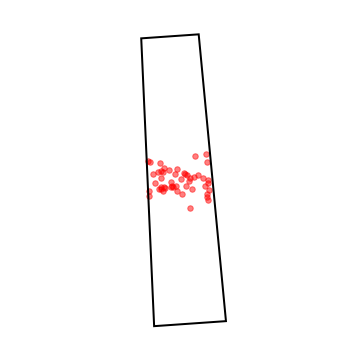
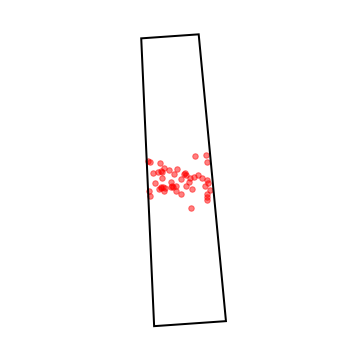
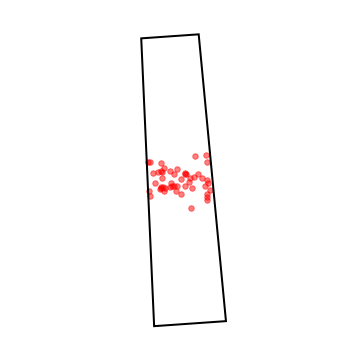
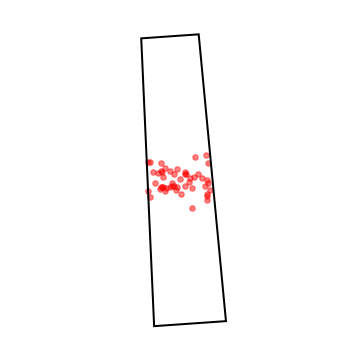
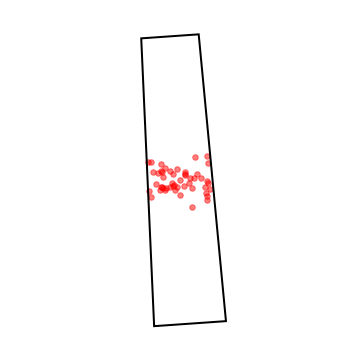
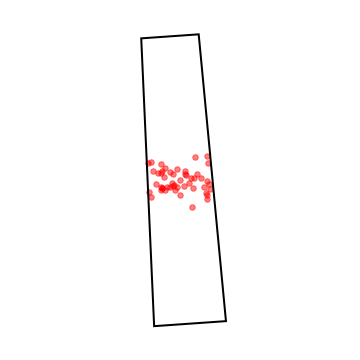
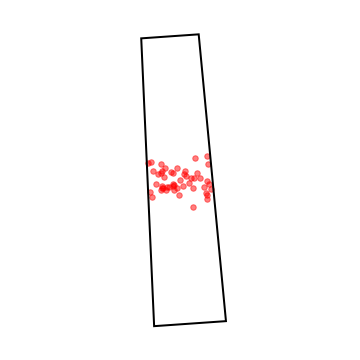
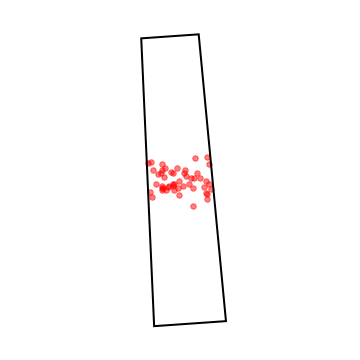
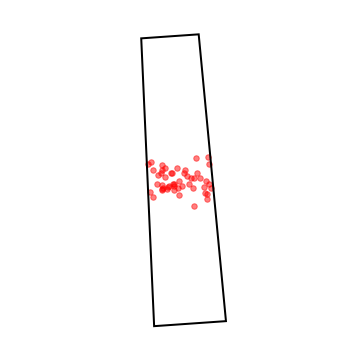
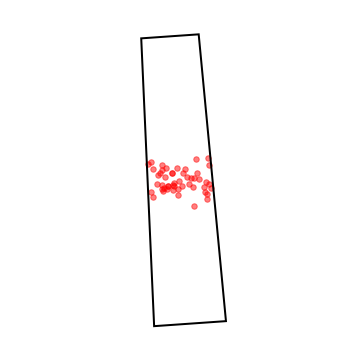
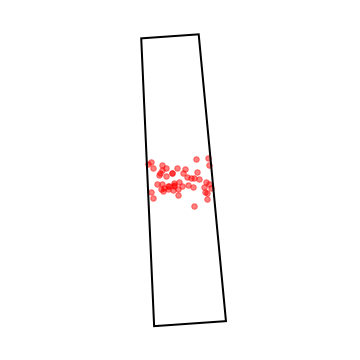
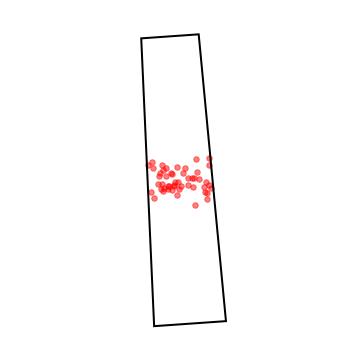
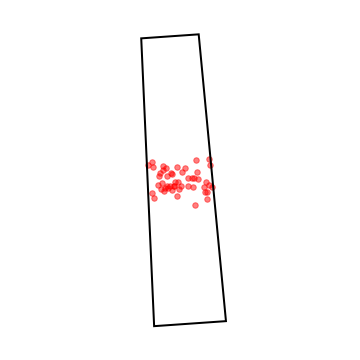
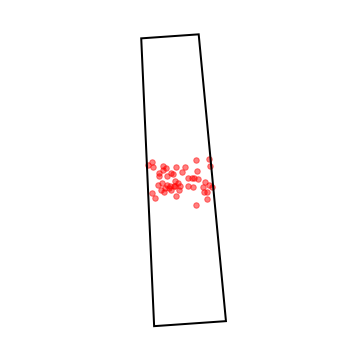
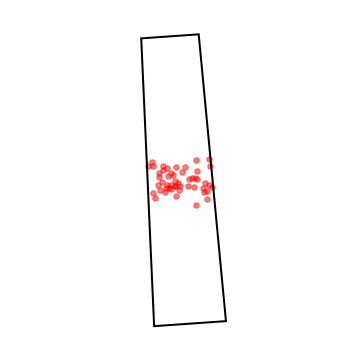
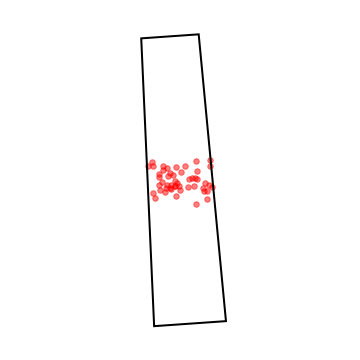
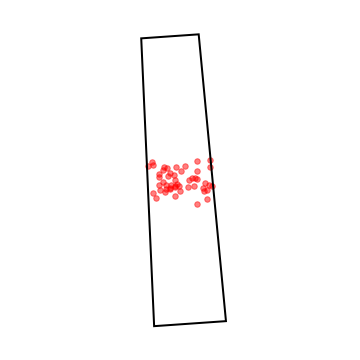
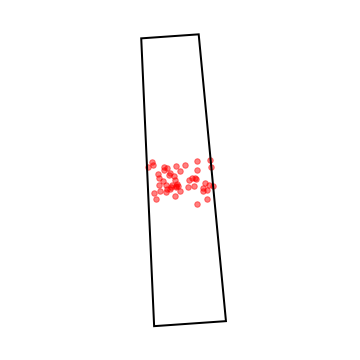
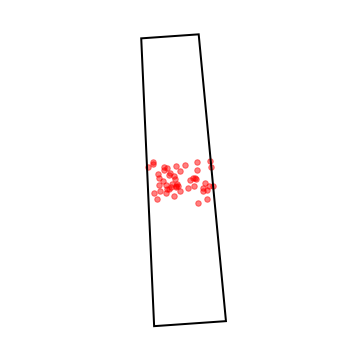

In [9]:
box = Box(50,4)
box.animate(saveQ=False)

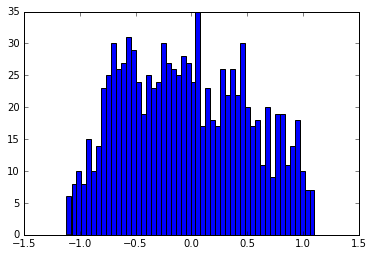

In [21]:
box = Box(1000,30)
box.momentum_focus()
